# Does maximisation of net carbon profit explain vegetation behaviour in savanna sites along a precipitation gradient?

It was shown by Whitley et al. (2016) that six models that expliticly included land surface exchange and vegetation dynamics (i.e. terrestial biosphere models, TBM's) were not able to represent, especially, the wet season dynamics in savanna regions. This reflects generally the simplicity used in the current generation TBM's with regard to modelling vegetation, which becomes especially apparent in the more complex ecosystems of savannas. The understanding of these more complex interactions between vegetation, water and climate in savanna-sites is therefore crucial in order to improve modelling with TBM's. 
Similar to the model inter-comparison presented by Whitley et al. (2016), in this study a coupled water-vegetation model (VOM, Schymanski et al. 2009) is applied in several savanna sites. In this case, vegetation properties are optimized for net carbon profit, instead of prescribing these.

The hypotheses tested are:

- Observed vegetation dynamics in tropical savanna sites can be explained by the maximization of Net Carbon Profit. 

- Optimization of vegetation properties for the Net Carbon Profit leads to reduced data requirements for Land Surface Models

- Carbon cost functions for roots, water transport system and foliage are valid along a precipitation gradient




# Results

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, date
from matplotlib.pyplot import imread
import matplotlib.cbook as cbook
from netCDF4 import Dataset

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Model comparison

### Ensemble years

Litchfield
Litchfield


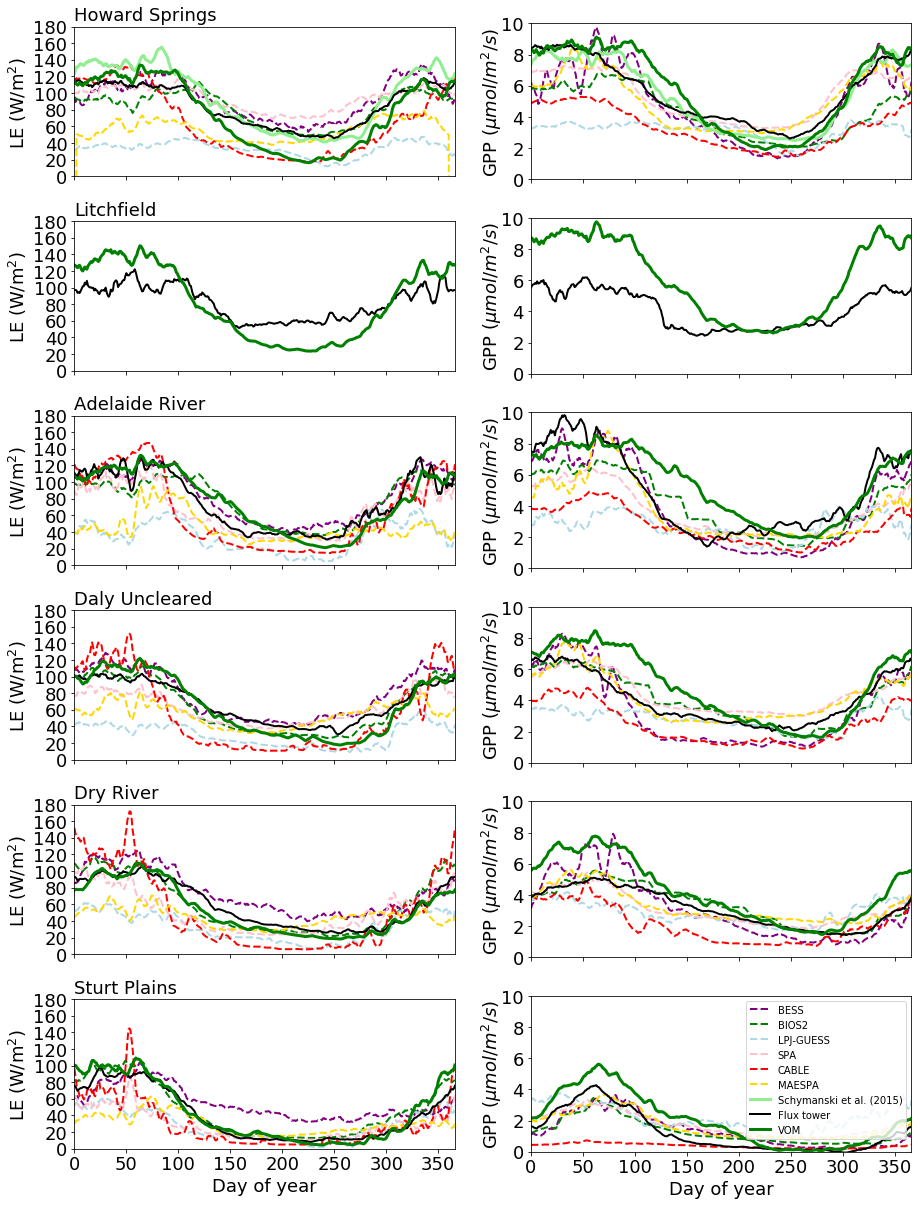

In [2]:
%run ../src_py/plot_ensembleyears.py \
--vom ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt ../data/VOM_output/Litchfield/freedrainage_cpcff1.0/sce_best/results_daily.txt ../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.0/sce_best/results_daily.txt ../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_best/results_daily.txt ../data/VOM_output/DryRiver/freedrainage_cpcff1.0/sce_best/results_daily.txt ../data/VOM_output/SturtPlains/freedrainage_cpcff1.0/sce_best/results_daily.txt \
--bess ~/Documents/data/SavMIP/BESS/HowardSprings.csv ~/Documents/data/SavMIP/BESS/AdelaideRiver.csv ~/Documents/data/SavMIP/BESS/DalyRiverUncleared.csv ~/Documents/data/SavMIP/BESS/DryRiver.csv ~/Documents/data/SavMIP/BESS/SturtPlains.csv \
--bios2 ~/Documents/data/SavMIP/BIOS2/HowardSprings_ET_GPP.csv ~/Documents/data/SavMIP/BIOS2/AdelaideRiver_ET_GPP.csv ~/Documents/data/SavMIP/BIOS2/DalyRiverUncleared_ET_GPP.csv ~/Documents/data/SavMIP/BIOS2/DryRiver_ET_GPP.csv ~/Documents/data/SavMIP/BIOS2/SturtPlains_ET_GPP.csv \
--lpjguess ~/Documents/data/SavMIP/LPJGUESS/howard_springs/howard_springs_et_eco.txt ~/Documents/data/SavMIP/LPJGUESS/adelaide_river/adelaide_river_et_eco.txt ~/Documents/data/SavMIP/LPJGUESS/daly_river_uncleared/daly_river_uncleared_et_eco.txt ~/Documents/data/SavMIP/LPJGUESS/dry_river/dry_river_et_eco.txt ~/Documents/data/SavMIP/LPJGUESS/sturt_plains/sturt_plains_et_eco.txt ~/Documents/data/SavMIP/LPJGUESS/howard_springs/howard_springs_gpp_eco.txt ~/Documents/data/SavMIP/LPJGUESS/adelaide_river/adelaide_river_gpp_eco.txt ~/Documents/data/SavMIP/LPJGUESS/daly_river_uncleared/daly_river_uncleared_gpp_eco.txt ~/Documents/data/SavMIP/LPJGUESS/dry_river/dry_river_gpp_eco.txt ~/Documents/data/SavMIP/LPJGUESS/sturt_plains/sturt_plains_gpp_eco.txt \
--maespa ~/Documents/data/SavMIP/MAESPA/HowardSprings_savannas_maespa_simulation.csv ~/Documents/data/SavMIP/MAESPA/AdelaideRiver_savannas_maespa_simulation.csv ~/Documents/data/SavMIP/MAESPA/DalyRiverUncleared_savannas_maespa_simulation.csv ~/Documents/data/SavMIP/MAESPA/DryRiver_savannas_maespa_simulation.csv ~/Documents/data/SavMIP/MAESPA/SturtPlains_savannas_maespa_simulation.csv \
--spa ~/Documents/data/SavMIP/SPAv1/howardsprings_hourly_outputs.csv ~/Documents/data/SavMIP/SPAv1/adelaideriver_hourly_outputs.csv ~/Documents/data/SavMIP/SPAv1/dalyriveruncleared_hourly_outputs.csv ~/Documents/data/SavMIP/SPAv1/dryriver_hourly_outputs.csv ~/Documents/data/SavMIP/SPAv1/sturtplains_hourly_outputs.csv \
--cable ~/Documents/data/SavMIP/CABLE/HowardSprings_CABLE.nc ~/Documents/data/SavMIP/CABLE/AdelaideRiver_CABLE.nc ~/Documents/data/SavMIP/CABLE/DalyRiverUncleared_CABLE.nc ~/Documents/data/SavMIP/CABLE/DryRiver_CABLE.nc ~/Documents/data/SavMIP/CABLE/SturtPlains_CABLE.nc \
--sites "Howard Springs" "Litchfield" "Adelaide River" "Daly Uncleared" "Dry River" "Sturt Plains" \
--whitley_sites 1 0 1 1 1 1 \
--dingo_et ../data/DINGO/Ea_howard.txt ../data/DINGO/Ea_litch.txt ../data/DINGO/Ea_adelaide.txt ../data/DINGO/Ea_daly.txt ../data/DINGO/Ea_dry.txt ../data/DINGO/Ea_sturt.txt \
--dingo_gpp ../data/DINGO/GPPdaily_howard.txt ../data/DINGO/GPPdaily_litch.txt ../data/DINGO/GPPdaily_adelaide.txt ../data/DINGO/GPPdaily_daly.txt ../data/DINGO/GPPdaily_dry.txt ../data/DINGO/GPPdaily_sturt.txt \
--i2015 ../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt 

#-o test.png

**Figure 3.** Ensemble years of latent energy (LE) and gross primary productivity (GPP) for the VOM (red), fluxtower observations (black), and several other LSM's (other colors).

It can be seen that:
- Results are similar compared to other models
- Seasonal amplitude correct
- Offset in transition between dry and wet period

### Measures of fit

In [3]:
#plot measures of fitness
bess_evap_stats = []
bess_evap_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/HowardSprings/evap_beststats.txt"))
bess_evap_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/AdelaideRiver/evap_beststats.txt"))
bess_evap_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/DalyUncleared/evap_beststats.txt"))
bess_evap_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/DryRiver/evap_beststats.txt"))
bess_evap_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/SturtPlains/evap_beststats.txt"))

bios2_evap_stats = []
bios2_evap_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/HowardSprings/evap_beststats.txt"))
bios2_evap_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/AdelaideRiver/evap_beststats.txt"))
bios2_evap_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/DalyUncleared/evap_beststats.txt"))
bios2_evap_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/DryRiver/evap_beststats.txt"))
bios2_evap_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/SturtPlains/evap_beststats.txt"))

cable_evap_stats = []
cable_evap_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/HowardSprings/evap_beststats.txt"))
cable_evap_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/AdelaideRiver/evap_beststats.txt"))
cable_evap_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/DalyUncleared/evap_beststats.txt"))
cable_evap_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/DryRiver/evap_beststats.txt"))
cable_evap_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/SturtPlains/evap_beststats.txt"))

lpjguess_evap_stats = []
lpjguess_evap_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/HowardSprings/evap_beststats.txt"))
lpjguess_evap_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/AdelaideRiver/evap_beststats.txt"))
lpjguess_evap_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/DalyUncleared/evap_beststats.txt"))
lpjguess_evap_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/DryRiver/evap_beststats.txt"))
lpjguess_evap_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/SturtPlains/evap_beststats.txt"))

maespa_evap_stats = []
maespa_evap_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/HowardSprings/evap_beststats.txt"))
maespa_evap_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/AdelaideRiver/evap_beststats.txt"))
maespa_evap_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/DalyUncleared/evap_beststats.txt"))
maespa_evap_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/DryRiver/evap_beststats.txt"))
maespa_evap_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/SturtPlains/evap_beststats.txt"))

spa_evap_stats = []
spa_evap_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/HowardSprings/evap_beststats.txt"))
spa_evap_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/AdelaideRiver/evap_beststats.txt"))
spa_evap_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/DalyUncleared/evap_beststats.txt"))
spa_evap_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/DryRiver/evap_beststats.txt"))
spa_evap_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/SturtPlains/evap_beststats.txt"))

In [4]:
#plot measures of fitness
bess_ass_stats = []
bess_ass_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/HowardSprings/ass_beststats.txt"))
bess_ass_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/AdelaideRiver/ass_beststats.txt"))
bess_ass_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/DalyUncleared/ass_beststats.txt"))
bess_ass_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/DryRiver/ass_beststats.txt"))
bess_ass_stats.append(np.genfromtxt("../data/SavMIP/BESS_stats/SturtPlains/ass_beststats.txt"))

bios2_ass_stats = []
bios2_ass_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/HowardSprings/ass_beststats.txt"))
bios2_ass_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/AdelaideRiver/ass_beststats.txt"))
bios2_ass_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/DalyUncleared/ass_beststats.txt"))
bios2_ass_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/DryRiver/ass_beststats.txt"))
bios2_ass_stats.append(np.genfromtxt("../data/SavMIP/BIOS2_stats/SturtPlains/ass_beststats.txt"))

cable_ass_stats = []
cable_ass_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/HowardSprings/ass_beststats.txt"))
cable_ass_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/AdelaideRiver/ass_beststats.txt"))
cable_ass_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/DalyUncleared/ass_beststats.txt"))
cable_ass_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/DryRiver/ass_beststats.txt"))
cable_ass_stats.append(np.genfromtxt("../data/SavMIP/CABLE_stats/SturtPlains/ass_beststats.txt"))

lpjguess_ass_stats = []
lpjguess_ass_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/HowardSprings/ass_beststats.txt"))
lpjguess_ass_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/AdelaideRiver/ass_beststats.txt"))
lpjguess_ass_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/DalyUncleared/ass_beststats.txt"))
lpjguess_ass_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/DryRiver/ass_beststats.txt"))
lpjguess_ass_stats.append(np.genfromtxt("../data/SavMIP/LPJGUESS_stats/SturtPlains/ass_beststats.txt"))

maespa_ass_stats = []
maespa_ass_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/HowardSprings/ass_beststats.txt"))
maespa_ass_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/AdelaideRiver/ass_beststats.txt"))
maespa_ass_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/DalyUncleared/ass_beststats.txt"))
maespa_ass_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/DryRiver/ass_beststats.txt"))
maespa_ass_stats.append(np.genfromtxt("../data/SavMIP/MAESPA_stats/SturtPlains/ass_beststats.txt"))

spa_ass_stats = []
spa_ass_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/HowardSprings/ass_beststats.txt"))
spa_ass_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/AdelaideRiver/ass_beststats.txt"))
spa_ass_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/DalyUncleared/ass_beststats.txt"))
spa_ass_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/DryRiver/ass_beststats.txt"))
spa_ass_stats.append(np.genfromtxt("../data/SavMIP/SPA_stats/SturtPlains/ass_beststats.txt"))

In [5]:
vom_evap_stats = []
vom_evap_stats.append(np.genfromtxt("../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt"))
vom_evap_stats.append(np.genfromtxt("../data/VOM_output/Litchfield/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt"))
vom_evap_stats.append(np.genfromtxt("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt"))
vom_evap_stats.append(np.genfromtxt("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt"))
vom_evap_stats.append(np.genfromtxt("../data/VOM_output/DryRiver/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt"))
vom_evap_stats.append(np.genfromtxt("../data/VOM_output/SturtPlains/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt"))

vom_pc1_evap_stats = []
vom_pc1_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/HowardSprings/sce_stats_best/evap_beststats.txt"))
vom_pc1_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/Litchfield/sce_stats_best/evap_beststats.txt"))
vom_pc1_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/AdelaideRiver/sce_stats_best/evap_beststats.txt"))
vom_pc1_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_stats_best/evap_beststats.txt"))
vom_pc1_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/DryRiver/sce_stats_best/evap_beststats.txt"))
vom_pc1_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/SturtPlains/sce_stats_best/evap_beststats.txt"))

vom_pc2_evap_stats = []
vom_pc2_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/HowardSprings/sce_stats_best/evap_beststats.txt"))
vom_pc2_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/Litchfield/sce_stats_best/evap_beststats.txt"))
vom_pc2_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/AdelaideRiver/sce_stats_best/evap_beststats.txt"))
vom_pc2_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/DalyUncleared/sce_stats_best/evap_beststats.txt"))
vom_pc2_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/DryRiver/sce_stats_best/evap_beststats.txt"))
vom_pc2_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/SturtPlains/sce_stats_best/evap_beststats.txt"))

vom_zr_evap_stats = []
vom_zr_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/HowardSprings/sce_stats_best/evap_beststats.txt"))
vom_zr_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/Litchfield/sce_stats_best/evap_beststats.txt"))
vom_zr_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/AdelaideRiver/sce_stats_best/evap_beststats.txt"))
vom_zr_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/DalyUncleared/sce_stats_best/evap_beststats.txt"))
vom_zr_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/DryRiver/sce_stats_best/evap_beststats.txt"))
vom_zr_evap_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/SturtPlains/sce_stats_best/evap_beststats.txt"))



In [6]:
#vom results
vom_ass_stats = []
vom_ass_stats.append(np.genfromtxt("../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt"))
vom_ass_stats.append(np.genfromtxt("../data/VOM_output/Litchfield/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt"))
vom_ass_stats.append(np.genfromtxt("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt"))
vom_ass_stats.append(np.genfromtxt("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt"))
vom_ass_stats.append(np.genfromtxt("../data/VOM_output/DryRiver/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt"))
vom_ass_stats.append(np.genfromtxt("../data/VOM_output/SturtPlains/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt"))

vom_pc1_ass_stats = []
vom_pc1_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/HowardSprings/sce_stats_best/ass_beststats.txt"))
vom_pc1_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/Litchfield/sce_stats_best/ass_beststats.txt"))
vom_pc1_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/AdelaideRiver/sce_stats_best/ass_beststats.txt"))
vom_pc1_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_stats_best/ass_beststats.txt"))
vom_pc1_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/DryRiver/sce_stats_best/ass_beststats.txt"))
vom_pc1_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover/SturtPlains/sce_stats_best/ass_beststats.txt"))

vom_pc2_ass_stats = []
vom_pc2_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/HowardSprings/sce_stats_best/ass_beststats.txt"))
vom_pc2_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/Litchfield/sce_stats_best/ass_beststats.txt"))
vom_pc2_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/AdelaideRiver/sce_stats_best/ass_beststats.txt"))
vom_pc2_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/DalyUncleared/sce_stats_best/ass_beststats.txt"))
vom_pc2_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/DryRiver/sce_stats_best/ass_beststats.txt"))
vom_pc2_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/prescribed_cover2/SturtPlains/sce_stats_best/ass_beststats.txt"))

vom_zr_ass_stats = []
vom_zr_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/HowardSprings/sce_stats_best/ass_beststats.txt"))
vom_zr_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/Litchfield/sce_stats_best/ass_beststats.txt"))
vom_zr_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/AdelaideRiver/sce_stats_best/ass_beststats.txt"))
vom_zr_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/DalyUncleared/sce_stats_best/ass_beststats.txt"))
vom_zr_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/DryRiver/sce_stats_best/ass_beststats.txt"))
vom_zr_ass_stats.append(np.genfromtxt("../data/VOM_output/additional_analyses/fixed_roots/SturtPlains/sce_stats_best/ass_beststats.txt"))



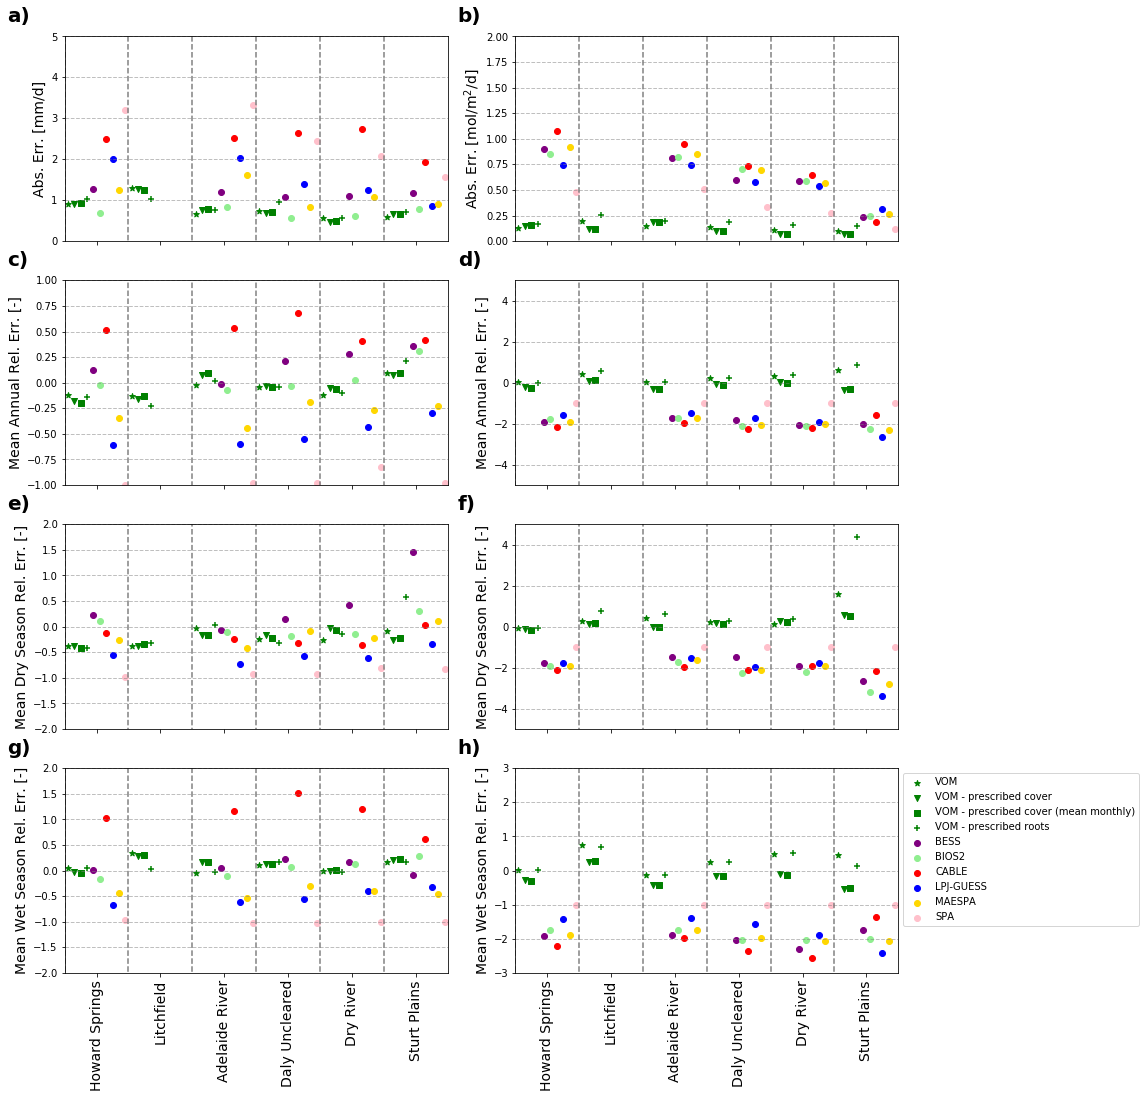

In [9]:
sites = [ "Howard Springs", "Litchfield", "Adelaide River", "Daly Uncleared", "Dry River", "Sturt Plains"  ]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16,15), sharex=True) 
ax=axes.flat

loc = 0.5
loc_vom =  np.arange(0.5, 60.5, 10)  
loc_vom2 =  np.arange(1.5, 61.5, 10)  
loc_vom3 =  np.arange(2.5, 62.5, 10)  
loc_vom4 =  np.arange(3.5, 63.5, 10)  

loc_bess = np.delete(np.arange(4.5, 64.5, 10),1)
loc_bios2 = np.delete(np.arange(5.5, 65.5, 10),1)
loc_cable = np.delete(np.arange(6.5, 66.5, 10),1)
loc_lpjguess = np.delete(np.arange(7.5, 67.5, 10),1)
loc_maespa = np.delete(np.arange(8.5, 68.5, 10),1)
loc_spa = np.delete(np.arange(9.5, 69.5, 10),1)


maxy= [5,2, 1,5, 2,5, 2,3]
miny= [0,0, -1,-5, -2,-5, -2,-3]

plot_label = [ "a)","b)","c)","d)","e)","f)", "g)", "h)" ] 

ylabels = [ "Abs. Err. [mm/d]",  
            "Abs. Err. [mol/m$^2$/d]", 
            "Mean Annual Rel. Err. [-]", 
            "Mean Annual Rel. Err. [-]", 
            "Mean Dry Season Rel. Err. [-]", 
            "Mean Dry Season Rel. Err. [-]", 
            "Mean Wet Season Rel. Err. [-]", 
            "Mean Wet Season Rel. Err. [-]", 
          ]

stats_order = [ 4,1,2,3]
iplot = 0

for i_stat in stats_order:
    
    #Evap
    ax[iplot].grid(color='gray', linestyle='dashed', axis="y")

    for i in range(0,len(vom_evap_stats)):    
        ax[iplot].plot( [loc_vom[i]-0.5, loc_vom[i]-0.5],[-9999,9999], "--", c="gray")    

    ax[iplot].scatter( loc_vom, np.array(vom_evap_stats[0:6])[:,i_stat], c="green", marker="*", label = "VOM"    )
    ax[iplot].scatter( loc_vom2, np.array(vom_pc1_evap_stats[0:6])[:,i_stat], c="green", marker="v", label = "VOM - prescribed cover"    )
    ax[iplot].scatter( loc_vom3, np.array(vom_pc2_evap_stats[0:6])[:,i_stat], c="green", marker="s", label = "VOM - prescribed cover (mean monthly)"    )
    ax[iplot].scatter( loc_vom4, np.array(vom_zr_evap_stats[0:6])[:,i_stat], c="green", marker="+", label = "VOM - prescribed roots"    )

    ax[iplot].scatter( loc_bess, np.array(bess_evap_stats[0:5])[:,i_stat] ,c = "purple", label = "BESS"  )
    ax[iplot].scatter( loc_bios2, np.array(bios2_evap_stats[0:5])[:,i_stat], c = "lightgreen", label = "BIOS2"   )
    ax[iplot].scatter( loc_cable, np.array(cable_evap_stats[0:5])[:,i_stat], c = "red", label = "CABLE"   )
    ax[iplot].scatter( loc_lpjguess, np.array(lpjguess_evap_stats[0:5])[:,i_stat], c = "blue", label = "LPJ-GUESS"   )
    ax[iplot].scatter( loc_maespa, np.array(maespa_evap_stats[0:5])[:,i_stat], c = "gold", label = "MAESPA"   )
    ax[iplot].scatter( loc_spa, np.array(spa_evap_stats[0:5])[:,i_stat], c = "pink", label="SPA"  )

    ax[iplot].grid(color='gray', linestyle='--', linewidth=1, alpha=0.5, axis="y")
    ax[iplot].set_ylim([ miny[iplot], maxy[iplot]])
    ax[iplot].set_xlim([0,60])
    ax[iplot].set_xticks( np.arange(5,65,10)  )
    ax[iplot].set_xticklabels( sites, rotation=90, fontsize=14  )        
    ax[iplot].set_ylabel( ylabels[iplot], fontsize=14  )    
    ax[iplot].text(-0.15, 1.07, plot_label[iplot], transform=ax[iplot].transAxes,  size=20, weight='bold')

    #GPP
    iplot = iplot + 1
    ax[iplot].grid(color='gray', linestyle='dashed', axis="y")

    for i in range(0,len(vom_evap_stats)):    
        ax[iplot].plot( [loc_vom[i]-0.5, loc_vom[i]-0.5],[-9999,9999], "--", c="gray")    

    ax[iplot].scatter( loc_vom, np.array(vom_ass_stats[0:6])[:,i_stat], c="green", marker="*", label = "VOM"    )
    ax[iplot].scatter( loc_vom2, np.array(vom_pc1_ass_stats[0:6])[:,i_stat], c="green", marker="v", label = "VOM - prescribed cover"    )
    ax[iplot].scatter( loc_vom3, np.array(vom_pc2_ass_stats[0:6])[:,i_stat], c="green", marker="s", label = "VOM - prescribed cover (mean monthly)"    )
    ax[iplot].scatter( loc_vom4, np.array(vom_zr_ass_stats[0:6])[:,i_stat], c="green", marker="+", label = "VOM - prescribed roots"    )

    ax[iplot].scatter( loc_bess, np.array(bess_ass_stats[0:5])[:,i_stat] ,c = "purple", label = "BESS"  )
    ax[iplot].scatter( loc_bios2, np.array(bios2_ass_stats[0:5])[:,i_stat], c = "lightgreen", label = "BIOS2"   )
    ax[iplot].scatter( loc_cable, np.array(cable_ass_stats[0:5])[:,i_stat], c = "red", label = "CABLE"   )
    ax[iplot].scatter( loc_lpjguess, np.array(lpjguess_ass_stats[0:5])[:,i_stat], c = "blue", label = "LPJ-GUESS"   )
    ax[iplot].scatter( loc_maespa, np.array(maespa_ass_stats[0:5])[:,i_stat], c = "gold", label = "MAESPA"   )
    ax[iplot].scatter( loc_spa, np.array(spa_ass_stats[0:5])[:,i_stat], c = "pink", label="SPA"  )

    ax[iplot].grid(color='gray', linestyle='--', linewidth=1, alpha=0.5, axis="y")
    ax[iplot].set_ylim([ miny[iplot], maxy[iplot]])
    ax[iplot].set_xlim([0,60])
    ax[iplot].set_xticks( np.arange(5,65,10)  )
    ax[iplot].set_xticklabels( sites, rotation=90, fontsize=14  ) 
    ax[iplot].set_ylabel( ylabels[iplot], fontsize=14   )    
    ax[iplot].text(-0.15, 1.07, plot_label[iplot], transform=ax[iplot].transAxes,  size=20, weight='bold')

    
    iplot = iplot + 1
   
    
plt.legend(bbox_to_anchor=(1, 1))  
plt.tight_layout()
plt.savefig("../data/img/4_fitness.png", bbox_inches = "tight")
plt.show()
    





**Figure 4.** Several measures of fit for the different VOM results and the models of Whitley et al (2016) in comparison with flux tower observations, with a) the mean absolute error for evaporation b) the mean absolute error for assimilation, c) the relative error for evaporation, d) the relative error for assimilation, e) the relative error for evaporation in the dry season (May-Sept.), f) the relative error for assimilation in the dry season (May-Sept.), f) the relative error for evaporation in the wet season (Dec.-March), g) the relative error for assimilation in the wet season (Dec.-March).

### Groundwater tables

/home/remko/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


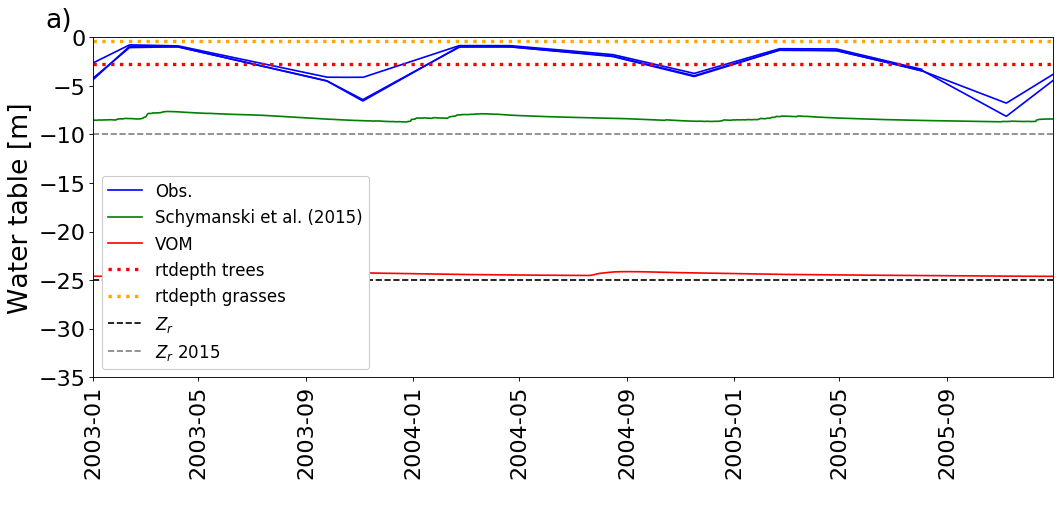

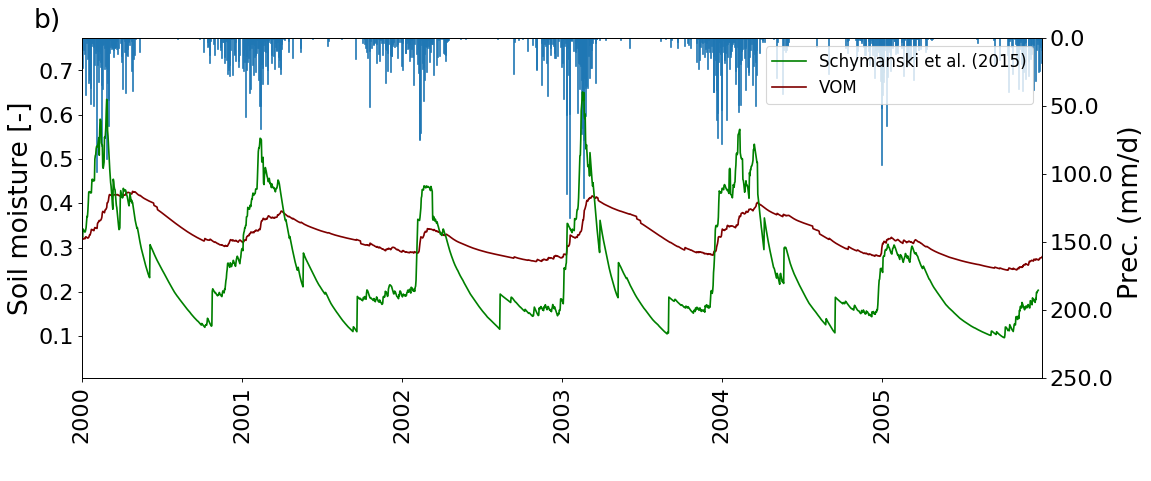

In [3]:
#plot groundwater tables
%run ../src_py/plot_gw.py  \
-i ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
--i2015 ../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt\
--depth True -ys 2003 -ye 2005 \
--ylabel "Water table [m]"  \
--labels VOM \
--colors "red" \
--i_cz 30  \
--i_zr 5 \
--i_cz2015 15 \
--i_zr2015 5 \
--obs ../data/boreholes/RN030982.csv \
../data/boreholes/RN030983.csv \
../data/boreholes/RN030984.csv \
--pars ../work/HowardSprings/freedrainage_cpcff1.0/best/input/pars.txt \
--legend True --xloc_title -0.05 --size_title 24 \
--outputfile "../data/img/5a_gw_depths.png" \
--ylim -35 0 --title "a)"

%run ../src_py/plot_et_ass.py  \
-i ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
--i2015 ../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-v su_avg --var2015 su_avg -ys 2000 -ye 2005 -w ../data/VOM_input/HowardSprings/dailyweather.prn \
--ylabel "Soil moisture [-]" --labels VOM \
--title "b)" --legend True --plot_prec True --xloc_title -0.05 --size_title 24 \
--outputfile "../data/img/5b_su_avg.png" \

#%run ../src_py/plot_et_ass.py  \
#-i ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
#--i2015 ../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
#-v ws --var2015 ws -ys 2003 -ye 2005 -w ../data/VOM_input/HowardSprings/dailyweather.prn \
#--ylabel "Total storage [m]" --labels VOM \
#--title "c)" --legend True --plot_prec True --xloc_title -0.05 --size_title 24 \

#%run ../src_py/plot_gw.py  \
#-i ../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.0/sce_best/results_daily.txt \
#--depth True -ys 2011 -ye 2015 \
#--ylabel "Water table [m]"  \
#--labels VOM \
#--colors "red" \
#--i_cz 30  \
#--pars ../work/AdelaideRiver/freedrainage_cpcff1.0/best/input/pars.txt \
#--title "b) " --legend True --xloc_title -0.05 --size_title 24 \
#--outputfile "../data/img/4b_gw_depths.png" \
#--ylim -35 0



**Figure 5.** Comparison for Howard Springs between the results from Schymanski et al. (2015) and the VOM-results for a) groundwater depths, and b) average soil moisture saturation for the unsaturated soil layers. Dashed lines in figure a) represent the depth of the drainage level, dotted lines the rooting depths (trees in red and grasses in orange), the VOM-results are shown in blue, the results of Schymanski et al. (2015) in green.

## Costfactor for water transport

### Effect on timeseries

<Figure size 1280x1200 with 0 Axes>

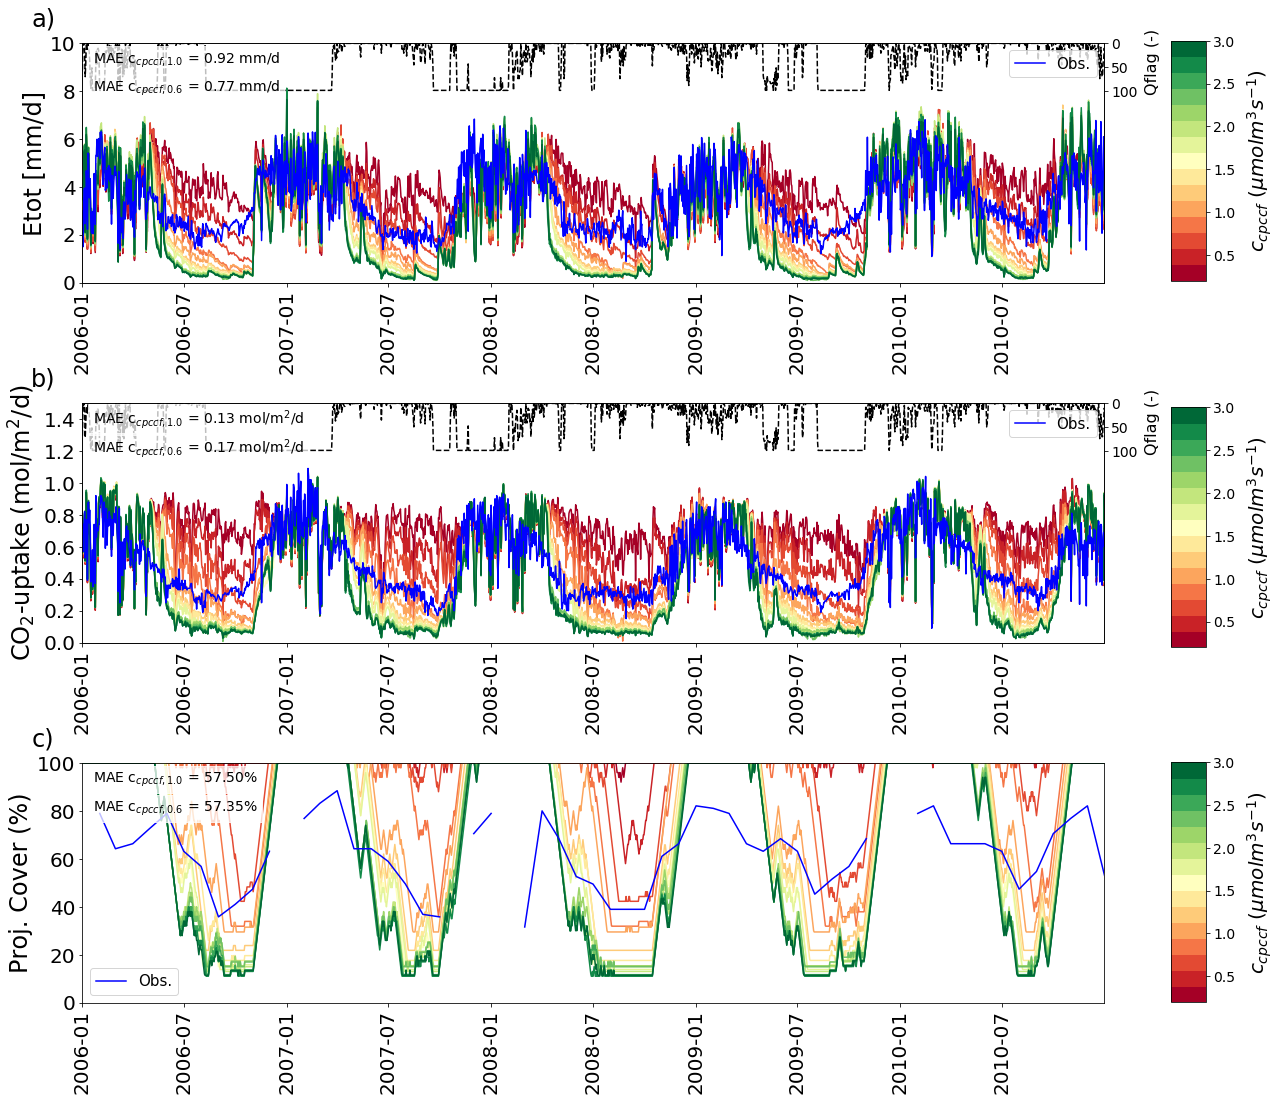

In [59]:
#HowardSprings
%run ../src_py/plot_et_ass_pc.py  \
-i ../data/VOM_output/HowardSprings/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.2/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.6/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff2.8/sce_best/results_daily.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff3.0/sce_best/results_daily.txt \
-ys 2006 -ye 2010 -w ../data/VOM_input/HowardSprings/dailyweather.prn \
--assobs ../data/DINGO/GPPdaily_howard.txt \
--assobs_qc ../data/DINGO_QC/FcQ_howard.txt \
--eobs_qc ../data/DINGO_QC/FeQ_howard.txt \
--eobs ../data/DINGO/Ea_howard.txt \
--pcobs ../data/fPAR/fpar_howard_v5.txt --pcobsdates ../data/fPAR/dates_v5 \
--labels "prescribed cover" "predicted cover" --legend True  \
--plot_cbar True --cblabel "$c_{cpccf}$ ($\mu mol m^3 s^{-1})$" --cbar_max 3.0 \
--stats_evap ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.6/sce_stats_best/evap_beststats.txt \
--stats_ass ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.6/sce_stats_best/ass_beststats.txt \
--stats_pc ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_stats_best/pc_beststats.txt \
../data/VOM_output/HowardSprings/freedrainage_cpcff0.6/sce_stats_best/pc_beststats.txt \
--stats_label "MAE c$_{cpccf,1.0}$"  "MAE c$_{cpccf,0.6}$" \
--xloc_title -0.05 --yloc_title 1.10  --size_title 24 --palette RdYlGn


**Figure 6.** VOM-results for different values of the costfactor cpcff (color scale) for HowardSprings, with a) the total evaporation, with fluxtower observations in blue b) CO$_2$-assimilation, with fluxtower observations in blue and c) projective cover, with the observed fraction of vegetation cover based on fPar-data (Donohue et al., 2008).

### Selecting cost factors

Constant cover:0.3971929824561404
Constant cover:0.32000000000000006
Constant cover:0.20771929824561405
Constant cover:0.37473684210526315
Constant cover:0.26616541353383455
Constant cover:0.07443609022556391


No handles with labels found to put in legend.


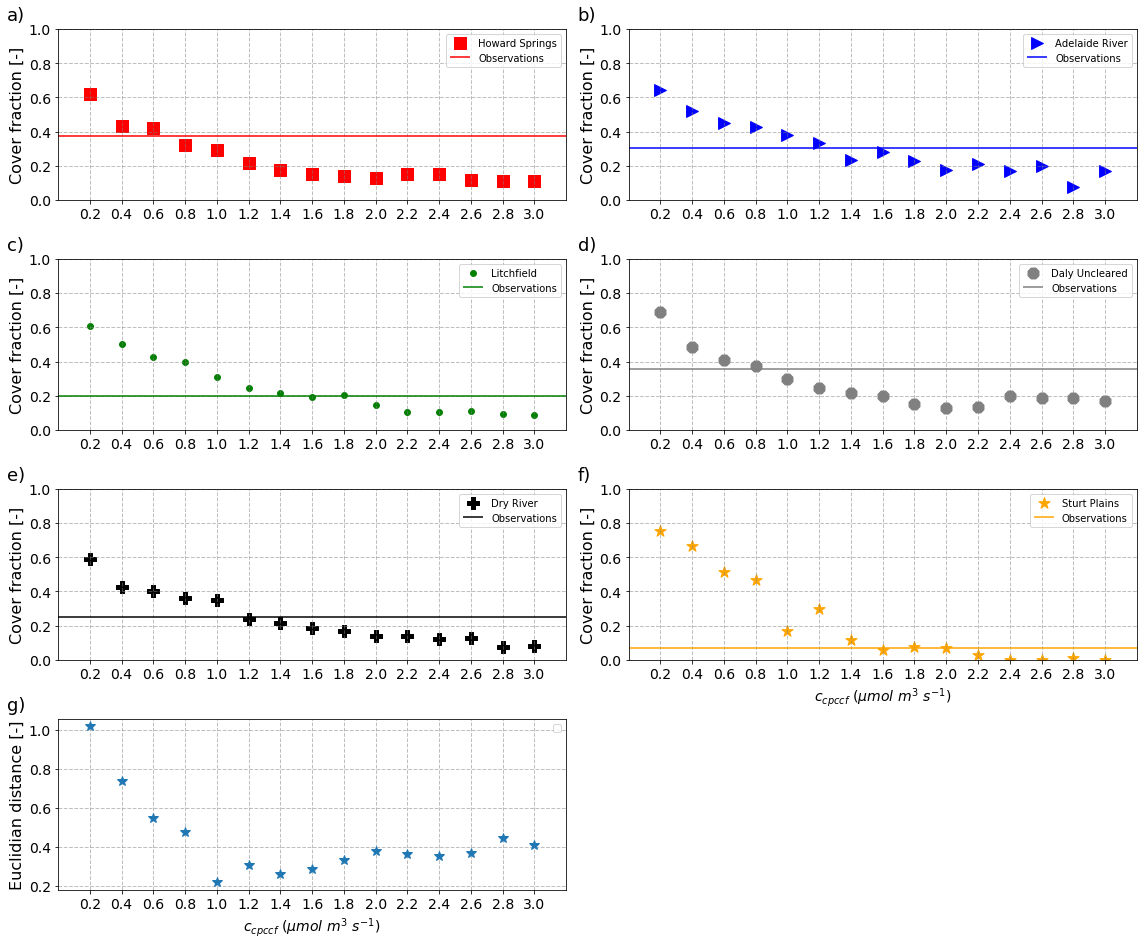

In [50]:
%run ../src_py/plot_costfactors.py --sites "Howard Springs" "Adelaide River" "Litchfield" "Daly Uncleared" "Dry River" "Sturt Plains" \
--cpccf_min 0.2 --cpccf_max 3.0 --cpccf_step 0.2 \
--in1 ../work/HowardSprings/freedrainage_cpcff0.2/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff0.4/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff0.6/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff0.8/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff1.0/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff1.2/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff1.4/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff1.6/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff1.8/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff2.0/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff2.2/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff2.4/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff2.6/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff2.8/best/input/pars.txt \
../work/HowardSprings/freedrainage_cpcff3.0/best/input/pars.txt \
--in2 ../work/AdelaideRiver/freedrainage_cpcff0.2/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff0.4/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff0.6/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff0.8/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff1.0/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff1.2/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff1.4/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff1.6/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff1.8/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff2.0/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff2.2/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff2.4/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff2.6/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff2.8/best/input/pars.txt \
../work/AdelaideRiver/freedrainage_cpcff3.0/best/input/pars.txt \
--in3 ../work/Litchfield/freedrainage_cpcff0.2/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff0.4/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff0.6/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff0.8/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff1.0/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff1.2/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff1.4/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff1.6/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff1.8/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff2.0/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff2.2/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff2.4/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff2.6/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff2.8/best/input/pars.txt \
../work/Litchfield/freedrainage_cpcff3.0/best/input/pars.txt \
--in4 ../work/DalyUncleared/freedrainage_cpcff0.2/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff0.4/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff0.6/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff0.8/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff1.0/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff1.2/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff1.4/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff1.6/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff1.8/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff2.0/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff2.2/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff2.4/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff2.6/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff2.8/best/input/pars.txt \
../work/DalyUncleared/freedrainage_cpcff3.0/best/input/pars.txt \
--in5 ../work/DryRiver/freedrainage_cpcff0.2/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff0.4/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff0.6/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff0.8/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff1.0/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff1.2/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff1.4/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff1.6/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff1.8/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff2.0/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff2.2/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff2.4/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff2.6/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff2.8/best/input/pars.txt \
../work/DryRiver/freedrainage_cpcff3.0/best/input/pars.txt \
--in6 ../work/SturtPlains/freedrainage_cpcff0.2/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff0.4/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff0.6/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff0.8/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff1.0/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff1.2/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff1.4/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff1.6/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff1.8/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff2.0/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff2.2/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff2.4/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff2.6/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff2.8/best/input/pars.txt \
../work/SturtPlains/freedrainage_cpcff3.0/best/input/pars.txt \
--fpar1 ../data/fPAR/fpar_howard_v5.txt --fpar2 ../data/fPAR/fpar_litchfield_v5.txt \
--fpar3 ../data/fPAR/fpar_adelaide_v5.txt  --fpar4 ../data/fPAR/fpar_daly_v5.txt --fpar5 ../data/fPAR/fpar_dry_v5.txt \
--fpar6 ../data/fPAR/fpar_sturt_v5.txt --fpar_dates ../data/fPAR/dates_v5 

**Figure 6.** Costfactor for the watertransport system (cpccf) versus the percentage vegetation cover in the dry season for the different sites a)-f) with modelled fraction of vegetation cover (symbols) and the for observed fraction of vegetation cover (line) based on fPar-data \citep{donohue_deriving_2008} and b) Euclidean distance based on the error for all six study sites between observed and modelled vegetation fractions for each cpcff-value, i.e. $ED =  \sqrt{ \sum_{i=1}^{n} E_{i}^2    }$, with $E_{i}$ the error for each site.


Conclusion:
- Optimal costfactor highly variable along the transect.
- Relations with other factors, such as temperatures, droughts, etc. needs to be investigated.


### Costfactor and climate indeces

In [6]:
def mean_annual(inputfile, var ,startyear, endyear, method):

    #load data
    data = np.genfromtxt(inputfile, names=True)

    #make numpy arrays in the right units
    vals = np.array(data[var]) #mm/d

    #create series of pandas time
    tmod = np.arange(datetime(int(data['fyear'][0]),int(data['fmonth'][0]),int(data['fday'][0])), 
                      datetime(int(data['fyear'][-1]),int(data['fmonth'][-1]),int(data['fday'][-1]))+timedelta(days=1), 
                      timedelta(days=1)).astype(datetime)
                    
    #make pandas series
    vals_pd = pd.Series(vals, index=tmod)
                    
    if(method == "sum"):
        vals_ma = np.mean(vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('A').sum() ) 
    if(method == "max"):
        vals_ma = np.mean(vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('A').max() ) 
    if(method == "min"):
        vals_ma = np.mean(vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('A').min() )

    
    return vals_ma      
                

In [7]:
prec_howard = mean_annual("../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_litch = mean_annual("../data/VOM_output/Litchfield/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_ade = mean_annual("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_daly = mean_annual("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_dry = mean_annual("../data/VOM_output/DryRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")
prec_sturt = mean_annual("../data/VOM_output/SturtPlains/freedrainage_cpcff1.2/sce_best/results_daily.txt", "rain" ,1995, 2015, "sum")

prec_all = [prec_howard, prec_litch, prec_ade, prec_daly, prec_dry, prec_sturt  ]

In [8]:
tmax_howard = mean_annual("../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_litch = mean_annual("../data/VOM_output/Litchfield/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_ade = mean_annual("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_daly = mean_annual("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_dry = mean_annual("../data/VOM_output/DryRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")
tmax_sturt = mean_annual("../data/VOM_output/SturtPlains/freedrainage_cpcff1.2/sce_best/results_daily.txt", "tairmax" ,1995, 2015, "max")

tmax_all = [tmax_howard, tmax_litch, tmax_ade, tmax_daly, tmax_dry, tmax_sturt  ]

In [9]:
def calc_netrad( weatherdata_file, lat, startyear, endyear ):
    
    #calculate net radiation, following FAO

    weatherdata = np.genfromtxt(weatherdata_file, names=True  )    
    
    #constants
    sigma = 4.903*10**-9 #Stefan-Boltzman constant [MJ K-4 m-2 day-1]
    Gsc = 0.0820 #solar constant [MJ m-2 hour-1]
    n = 10 #220/31 #sunshine hours
    N = 10 #maximum sunshine hours
    
    #get data from VOM-dailyweather
    Rs = weatherdata["Radn"]    # incoming solar radiation [MJ m-2 day-1]
    Tmax = weatherdata["TMax"]  # Celsius
    Tmin = weatherdata["TMin"]  # Celsius
    ea = weatherdata["VP"] /10  # kPa

    #define time and dates
    time = np.arange(datetime(int(weatherdata['Year'][0]),int(weatherdata['Month'][0]),int(weatherdata['Day'][0])), 
                  datetime(int(weatherdata['Year'][-1]),int(weatherdata['Month'][-1]),int(weatherdata['Day'][-1]))+timedelta(days=1), 
                  timedelta(days=1)).astype(datetime)
    time_pd = pd.date_range(time[0],periods=len( time ), freq='D')

    #day of year
    J = time_pd.dayofyear
    
    #inverse relative distance Earth-Sun
    dr =  1 + 0.033*np.cos(2*np.pi*J/365)  # [m?]

    phi=  (np.pi/180) * lat   #latitude [rad]
    
    #solar declination
    delta= 0.409*np.sin( (2*J*np.pi/365)  - 1.39 ) #[rad]
    
    #sunset hour angle
    ws =  np.arccos(-np.tan(phi)*np.tan(delta))

    #extraterrestrial radiation
    part1 = (24*60/np.pi) * Gsc * dr 
    part2 = ws*np.sin(phi)*np.sin(delta)
    part3 = np.cos(phi)*np.cos(delta)*np.sin(ws) 

    Ra =  part1*(part2+part3)  #[MJ m-2 hr-1]


    #Rso = Ra*z*0.75*2*10**-5
    Rso = Ra*(0.25+0.5*(n/N)) #clear-sky solar radiation [MJ m-2 day-1]

    Rns = (1-0.23) * Rs # shortwave radiation

    part1 = sigma*((Tmax+273.16)**4 + (Tmin+273.16)**4)/2
    part2 = 0.34-0.14*np.sqrt(ea)
    part3 = 1.35*Rs/Rso -0.35

    Rnl = part1 * part2 * part3 #net longwave radiation [MJ m-2 day-1]

    Rn = Rns - Rnl
    
    Rn_pd = pd.Series(Rn, index = time_pd)
    Rn_pd = Rn_pd[ (Rn_pd.index.year>=startyear) & (Rn_pd.index.year<=endyear)]
    
    return Rn_pd

In [10]:
def aridity(rn, input_vom, startyear, endyear):
       
    
    #input: results vom
    #precipitation
    #potential evaporation
    #net radiation
    
    weatherdata = np.genfromtxt(input_vom, names=True  )

    #define time and dates
    time = np.arange(datetime(int(weatherdata['Year'][0]),int(weatherdata['Month'][0]),int(weatherdata['Day'][0])), 
                  datetime(int(weatherdata['Year'][-1]),int(weatherdata['Month'][-1]),int(weatherdata['Day'][-1]))+timedelta(days=1), 
                  timedelta(days=1)).astype(datetime)
    time_pd = pd.date_range(time[0],periods=len( time ), freq='D')
    
    
    lat_heat_vapor = 2.45   #[MJ/kg] 
    rho_w = 1000             #[kg/m3]

    prec = pd.Series(weatherdata['Rain'], index=time_pd)
    prec = prec[ (prec.index.year>=startyear) & (prec.index.year<=endyear)]
    #rn = np.array(rn)  
    ep = 1000*rn/(lat_heat_vapor*rho_w) #mm/d
    Lp = prec * lat_heat_vapor 
    
    
    #in terms of water, prec as base
    EpP = np.sum(ep) / np.sum(prec) 
        
    #in terms of energy  
    RnLp = np.sum(rn) / np.sum(Lp) #same as Ep/P    

    return EpP, RnLp


In [11]:
def mean_annual_silo(meteofile, column):

    meteo_data = pd.read_csv(meteofile, skiprows = 43, delimiter=r"\s+", header=None )

   #make a pandas datetime series
    pddatetime = pd.to_datetime( meteo_data[2], format="%d-%m-%Y")

    #make a pandas index
    index = pd.DatetimeIndex( pddatetime)

    #replace index
    meteo_data.index = index
    
    #extract the variable of interest
    var = meteo_data[:][column]
    
    #print(var.resample("Y").sum())
    #calculate the mean annual value
    MA_var = np.mean(var.resample("Y").sum())
    
    return MA_var



In [12]:
EPade_fao = mean_annual_silo("../data/Silo/adelaide.txt",  17)
EPdal_fao = mean_annual_silo("../data/Silo/daly.txt",  17)
EPdry_fao = mean_annual_silo("../data/Silo/dry.txt",  17)
EPhs_fao = mean_annual_silo("../data/Silo/howard.txt",  17)
EPlf_fao = mean_annual_silo("../data/Silo/litchfield.txt",  17)
EPsturt_fao = mean_annual_silo("../data/Silo/sturt.txt",  17)

EP_fao = [EPhs_fao, EPlf_fao, EPade_fao, EPdal_fao, EPdry_fao, EPsturt_fao ]

#FAO56

In [13]:
rn_howard = calc_netrad("../data/VOM_input/HowardSprings/dailyweather.prn", -12.5,1995, 2015)
rn_litch = calc_netrad("../data/VOM_input/Litchfield/dailyweather.prn", -13.1790,1995, 2015)
rn_ade = calc_netrad("../data/VOM_input/AdelaideRiver/dailyweather.prn", -13.077,1995, 2015)
rn_daly = calc_netrad("../data/VOM_input/DalyUncleared/dailyweather.prn", -14.1592,1995, 2015)
rn_dry = calc_netrad("../data/VOM_input/DryRiver/dailyweather.prn", -15.2587833333333 ,1995, 2015)
rn_sturt = calc_netrad("../data/VOM_input/SturtPlains/dailyweather.prn", -17.1507,1995, 2015)

aridity_howard = aridity(rn_howard, "../data/VOM_input/HowardSprings/dailyweather.prn",1995, 2015)
aridity_litch = aridity(rn_litch, "../data/VOM_input/Litchfield/dailyweather.prn",1995, 2015)
aridity_ade = aridity(rn_ade, "../data/VOM_input/AdelaideRiver/dailyweather.prn",1995, 2015)
aridity_daly = aridity(rn_daly, "../data/VOM_input/DalyUncleared/dailyweather.prn",1995, 2015)
aridity_dry = aridity(rn_dry, "../data/VOM_input/DryRiver/dailyweather.prn",1995, 2015)
aridity_sturt = aridity(rn_sturt, "../data/VOM_input/SturtPlains/dailyweather.prn",1995, 2015)

aridity = [aridity_howard, aridity_litch, aridity_ade, aridity_daly, aridity_dry, aridity_sturt ]

In [14]:
startyear = 1995
endyear = 2015

rn_howard_ma = np.mean(rn_howard[ (rn_howard.index.year>=startyear) & (rn_howard.index.year<=endyear)].resample('A').sum() ) 
rn_litch_ma = np.mean(rn_litch[ (rn_litch.index.year>=startyear) & (rn_litch.index.year<=endyear)].resample('A').sum() ) 
rn_ade_ma = np.mean(rn_ade[ (rn_ade.index.year>=startyear) & (rn_ade.index.year<=endyear)].resample('A').sum() ) 
rn_daly_ma = np.mean(rn_daly[ (rn_daly.index.year>=startyear) & (rn_daly.index.year<=endyear)].resample('A').sum() ) 
rn_dry_ma = np.mean(rn_dry[ (rn_dry.index.year>=startyear) & (rn_dry.index.year<=endyear)].resample('A').sum() ) 
rn_sturt_ma = np.mean(rn_sturt[ (rn_sturt.index.year>=startyear) & (rn_sturt.index.year<=endyear)].resample('A').sum() ) 

rn_ma = [rn_howard_ma, rn_litch_ma, rn_ade_ma, rn_daly_ma, rn_dry_ma, rn_sturt_ma ]

In [15]:
def rainfall_seasonality(inputfile,startyear, endyear, method):

    #load data
    data = np.genfromtxt(inputfile, names=True)

    #make numpy arrays in the right units
    vals = np.array(data["Rain"]) #mm/d

    #create series of pandas time
    tmod = np.arange(datetime(int(data['Year'][0]),int(data['Month'][0]),int(data['Day'][0])), 
                      datetime(int(data['Year'][-1]),int(data['Month'][-1]),int(data['Day'][-1]))+timedelta(days=1), 
                      timedelta(days=1)).astype(datetime)
                    
    #make pandas series
    vals_pd = pd.Series(vals, index=tmod)
    vals_pd = vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)]

    
    if(method == "mean_annual"):
        Pma = np.mean(vals_pd.resample('A').sum() ) 
        Pmonth = vals_pd.resample('M').sum()
        Pmm = np.zeros(12) #mean monthly rainfall
        for i in range(1,13):
            Pmm_tmp = np.mean(Pmonth[Pmonth.index.month == i])
            Pmm[i-1] = Pmm_tmp


        seasonality =  (1/Pma) * np.sum( np.abs(Pmm - (Pma / 12)) )
        
    if(method == "annual_values"):
        Pma = vals_pd.resample('A').sum() 
        Pmonth = vals_pd.resample('M').sum()
        Pmm = np.zeros( (len(vals_pd.resample('A').sum()),12)) #mean monthly rainfall
        for i in range(1,13):
            Pmm_tmp = Pmonth[Pmonth.index.month == i]            
            Pmm[:, i-1] = Pmm_tmp

        seasonality = np.zeros(len(Pma))
        for i in range(0, len(Pma) ):
            seasonality[i] =  (1/Pma[i]) * np.sum( np.abs(Pmm[i,:] - (Pma[i] / 12)) )
        
    return seasonality      
                

In [16]:
seas_howard = rainfall_seasonality("../data/VOM_input/HowardSprings/dailyweather.prn",1995, 2015, "mean_annual")
seas_litch = rainfall_seasonality("../data/VOM_input/Litchfield/dailyweather.prn", 1995, 2015, "mean_annual")
seas_ade = rainfall_seasonality("../data/VOM_input/AdelaideRiver/dailyweather.prn", 1995, 2015, "mean_annual")
seas_daly = rainfall_seasonality("../data/VOM_input/DalyUncleared/dailyweather.prn", 1995, 2015, "mean_annual")
seas_dry = rainfall_seasonality("../data/VOM_input/DryRiver/dailyweather.prn" ,1995, 2015, "mean_annual")
seas_sturt = rainfall_seasonality("../data/VOM_input/SturtPlains/dailyweather.prn", 1995, 2015, "mean_annual")

seas = [seas_howard, seas_litch, seas_ade, seas_daly, seas_dry, seas_sturt ]


In [17]:
def dry_season(inputfile,startyear, endyear):

    #load data
    data = np.genfromtxt(inputfile, names=True)

    #make numpy arrays in the right units
    vals = np.array(data["Rain"]) #mm/d

    #create series of pandas time
    tmod = np.arange(datetime(int(data['Year'][0]),int(data['Month'][0]),int(data['Day'][0])), 
                      datetime(int(data['Year'][-1]),int(data['Month'][-1]),int(data['Day'][-1]))+timedelta(days=1), 
                      timedelta(days=1)).astype(datetime)
                    
    #make pandas series
    vals_pd = pd.Series(vals, index=tmod)
    vals_pd = vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)]
    
    

    dry_period = np.zeros( len(np.arange(startyear,endyear+1))) #yearly dry periods
    i = 0
    for iyear in np.arange(startyear,endyear+1):
        tmp = vals_pd[vals_pd.index.year == iyear]
        dry_period[i] = tmp.value_counts().max()
        i = i + 1
    
        
    dryseason_duration =  np.mean(dry_period)
        
    return dryseason_duration      
                

In [18]:
drydur_howard = dry_season("../data/VOM_input/HowardSprings/dailyweather.prn",1995, 2015)
drydur_litch = dry_season("../data/VOM_input/Litchfield/dailyweather.prn", 1995, 2015)
drydur_ade = dry_season("../data/VOM_input/AdelaideRiver/dailyweather.prn", 1995, 2015)
drydur_daly = dry_season("../data/VOM_input/DalyUncleared/dailyweather.prn", 1995, 2015)
drydur_dry = dry_season("../data/VOM_input/DryRiver/dailyweather.prn" ,1995, 2015)
drydur_sturt = dry_season("../data/VOM_input/SturtPlains/dailyweather.prn", 1995, 2015)

drydur = [drydur_howard, drydur_litch, drydur_ade, drydur_daly, drydur_dry, drydur_sturt  ]


In [19]:
#determine best cpcff
cpcff_vals = np.arange(0.2,2.8, 0.2)
study_sites = ["HowardSprings", "AdelaideRiver", "Litchfield", "DalyUncleared", "DryRiver", "SturtPlains" ]

cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)

cai_fpar = [0.3971929824561404, #HowardSprings
0.20771929824561405, #AdelaideRiver
0.32000000000000006, #Litchfield
0.37473684210526315, #DalyUncleared
0.26616541353383455, #DryRiver
0.07443609022556391 #SturtPlains
] 

err = np.zeros((len(cpcff_vals),6))
cpcff_best = np.zeros(6)


ibasin = 0
for site in study_sites:

    i_cpcff = 0
    

    for cpcff in  cpcff_str: 
        try:
            params = np.loadtxt("../work/"+  site  +"/freedrainage_cpcff" + cpcff +
                      "/best/input/pars.txt")

            cai = params[4]              
            err[i_cpcff, ibasin] = np.abs(cai - cai_fpar[ibasin])
            
        except OSError:
            print('file not found')
         
        i_cpcff = i_cpcff + 1
        
        
    cpcff_best[ibasin] = cpcff_vals[err[:,ibasin] == min(err[:,ibasin])]
    ibasin = ibasin + 1    

<Figure size 1280x400 with 0 Axes>

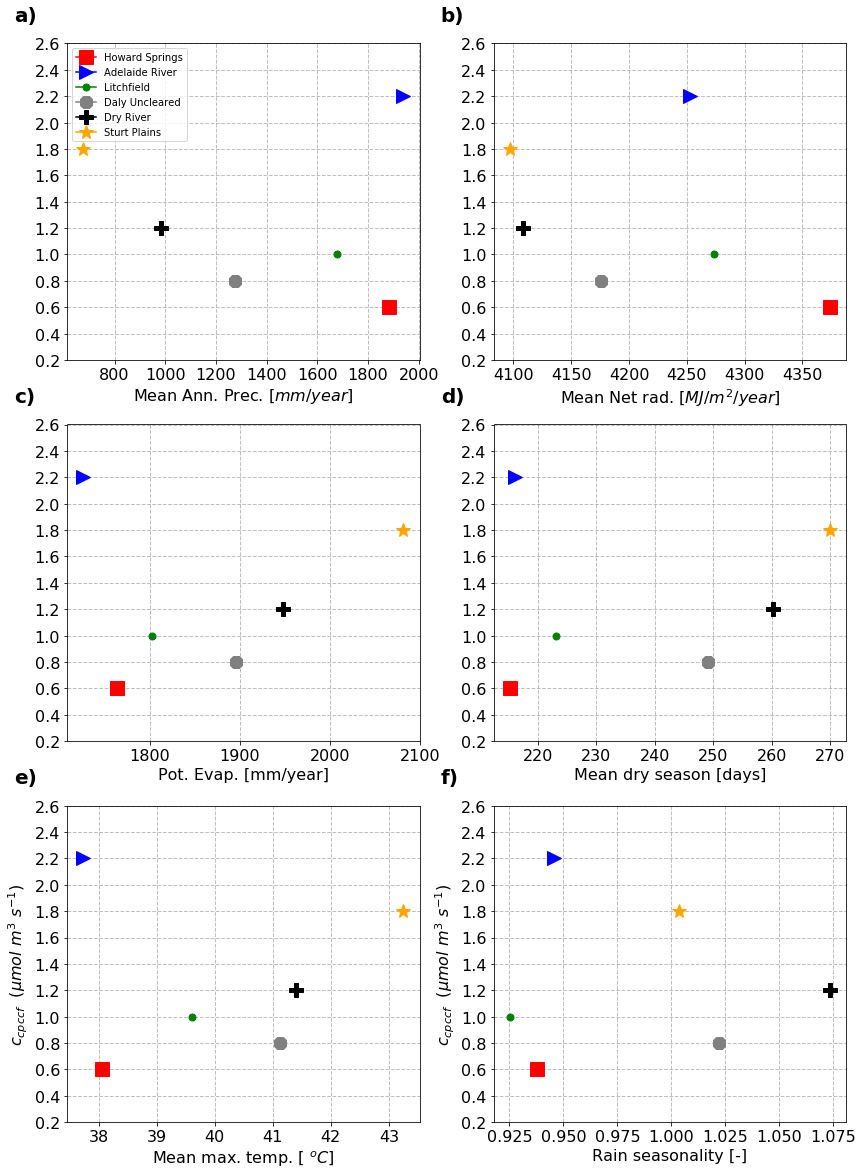

In [20]:
#plot parameters
cpcff_vals = np.arange(0.2,2.8, 0.2)
study_sites = ["Howard Springs", "Adelaide River", "Litchfield", "Daly Uncleared", "Dry River", "Sturt Plains" ]

cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)

cai_fpar = [0.3971929824561404, #HowardSprings
0.20771929824561405, #AdelaideRiver
0.32000000000000006, #Litchfield
0.37473684210526315, #DalyUncleared
0.26616541353383455, #DryRiver
0.07443609022556391 #SturtPlains
] 

err = np.zeros((len(cpcff_vals),6))
ED = np.zeros((len(cpcff_vals)))

symbols = ['s', '>', '.','8', 'P','*']
colors = ['red', 'blue', 'green', 'gray', 'black', 'orange']

xlabel = ["Mean Ann. Prec. [$mm/year$]",
          r"Mean Net rad. [$MJ/m^{2}/year$]",
          "Pot. Evap. [mm/year]",
          "Mean dry season [days]",
          "Mean max. temp. [ $^o C$]",
          "Rain seasonality [-]"        
         ]

fig=plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16)) 
ax = axes.flat

isite = 0

for site in study_sites:


    ax[0].plot( prec_all[isite], cpcff_best[isite], marker=symbols[isite], color=colors[isite] , markersize=14, label=study_sites[isite])     
    ax[1].plot(rn_ma[isite], cpcff_best[isite],  marker=symbols[isite], color=colors[isite] , markersize=14, label=study_sites[isite])     
    ax[2].plot(EP_fao[isite], cpcff_best[isite],  marker=symbols[isite], color=colors[isite] , markersize=14, label=study_sites[isite])     
    ax[3].plot(drydur[isite], cpcff_best[isite],  marker=symbols[isite], color=colors[isite] , markersize=14, label=study_sites[isite])     
    ax[4].plot(tmax_all[isite], cpcff_best[isite],  marker=symbols[isite], color=colors[isite] , markersize=14, label=study_sites[isite])     
    ax[5].plot( seas[isite], cpcff_best[isite], marker=symbols[isite], color=colors[isite] , markersize=14, label=study_sites[isite])     

    isite = isite + 1

    
ax[0].legend(prop={'size':10})

for i in range(0,6):
    ax[i].set_xlabel(xlabel[i], size=16 )  
    ax[i].tick_params(axis='both', which='major', labelsize=16)
    ax[i].set_yticks(cpcff_vals)
    ax[i].set_yticklabels(cpcff_str)
    ax[i].grid(color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax[i].tick_params(axis='both', which='major', labelsize=16)

ax[4].set_ylabel(r'$c_{cpccf}$  ($\mu$$mol$ $m^3$ $s^{-1}$)', size=16 )  
ax[5].set_ylabel(r'$c_{cpccf}$  ($\mu$$mol$ $m^3$ $s^{-1}$)', size=16 )  


ax[0].text(-0.15, 1.07, "a)", transform=ax[0].transAxes,  size=20, weight='bold')
ax[1].text(-0.15, 1.07, "b)", transform=ax[1].transAxes,  size=20, weight='bold')
ax[2].text(-0.15, 1.07, "c)", transform=ax[2].transAxes,  size=20, weight='bold')
ax[3].text(-0.15, 1.07, "d)", transform=ax[3].transAxes,  size=20, weight='bold')
ax[4].text(-0.15, 1.07, "e)", transform=ax[4].transAxes,  size=20, weight='bold')
ax[5].text(-0.15, 1.07, "f)", transform=ax[5].transAxes,  size=20, weight='bold')

plt.tight_layout()
    
plt.savefig("../data/img/8_cpcff_climate.png", bbox_inches = "tight")
plt.show()


**Figure 8.** Selected costfactor for the watertransport system (cpcff) for each study site versus several climatic indeces, with a) mean annual precipitation, b) mean net radiation, c) aridity, d) mean length of the dry season, e) mean maximum temperature and f) mean rainfall seasonality.

## Foliage

### Effect carbon costs on timeseries

<Figure size 1280x1200 with 0 Axes>

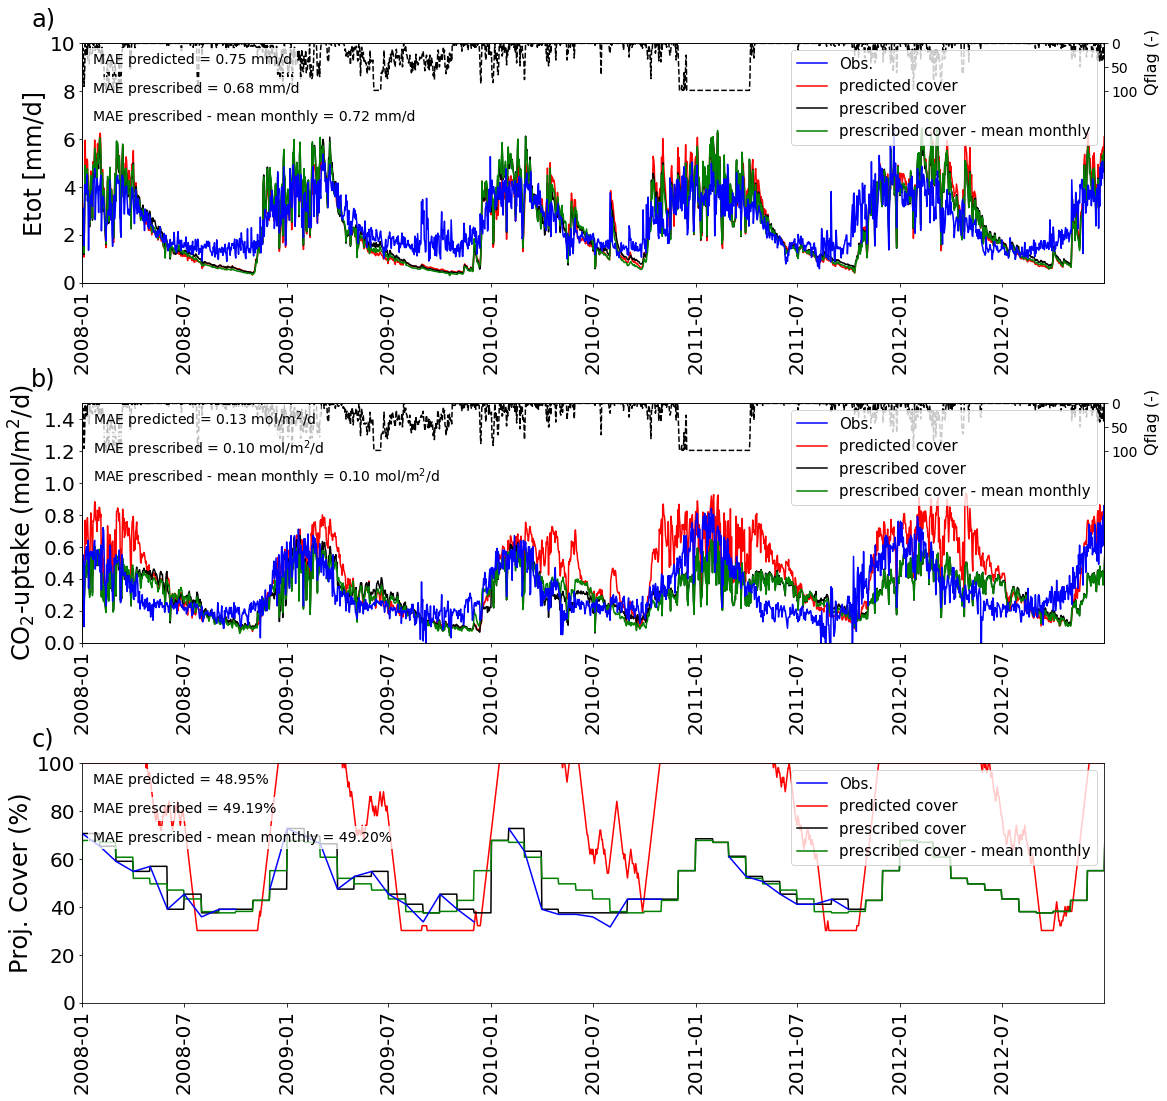

In [66]:
#DalyUncleared
%run ../src_py/plot_et_ass_pc.py  \
-i ../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_best/results_daily.txt \
../data/VOM_output/additional_analyses/prescribed_cover2/DalyUncleared/sce_best/results_daily.txt \
-ys 2008 -ye 2012 -w ../data/VOM_input/DalyUncleared/dailyweather.prn \
--assobs ../data/DINGO/GPPdaily_daly.txt \
--assobs_qc ../data/DINGO_QC/FcQ_daly.txt \
--eobs_qc ../data/DINGO_QC/FeQ_daly.txt \
--eobs ../data/DINGO/Ea_daly.txt \
--colors "red" "black" "green" \
--pcobs ../data/fPAR/fpar_daly_v5.txt --pcobsdates ../data/fPAR/dates_v5 \
--labels "predicted cover" "prescribed cover" "prescribed cover - mean monthly" --legend True  \
--stats_evap ../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt \
../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_stats_best/evap_beststats.txt\
../data/VOM_output/additional_analyses/prescribed_cover2/DalyUncleared/sce_stats_best/evap_beststats.txt\
--stats_ass ../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt \
../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_stats_best/ass_beststats.txt \
../data/VOM_output/additional_analyses/prescribed_cover2/DalyUncleared/sce_stats_best/ass_beststats.txt \
--stats_pc ../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_stats_best/pc_beststats.txt \
../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_stats_best/pc_beststats.txt \
../data/VOM_output/additional_analyses/prescribed_cover2/DalyUncleared/sce_stats_best/pc_beststats.txt \
--stats_label "MAE predicted"  "MAE prescribed" "MAE prescribed - mean monthly" \
--xloc_title -0.05 --yloc_title 1.10  --size_title 24 


**Figure 9.** Comparison between the VOM with prescribed and predicted vegetation cover, for a) assimilation and b) evaporation, with model results obtained by the prescribed cover in red, the predicted cover in grey and the fluxtower observations in blue.

### Flux partitioning

In [22]:
def fluxpartitions(inputfile, startyear, endyear, startwet, endwet, startdry, enddry):

    #load data
    data = np.genfromtxt(inputfile, names=True)

    #make numpy arrays in the right units
    esoil = 1000*np.array(data["esoil"]) #mm/d
    etmt = 1000*np.array(data["etmt"])   #mm/d
    etmg = 1000*np.array(data["etmg"])   #mm/d
    assg = np.array(data["assg"])        #mol/m2/d
    asst = np.array(data["asst"])        #mol/m2/d

    #create series of pandas time
    tmod = np.arange(datetime(int(data['fyear'][0]),int(data['fmonth'][0]),int(data['fday'][0])), 
                      datetime(int(data['fyear'][-1]),int(data['fmonth'][-1]),int(data['fday'][-1]))+timedelta(days=1), 
                      timedelta(days=1)).astype(datetime)
                    
    #make pandas series
    esoil_pd = pd.Series(esoil, index=tmod)
    etmt_pd = pd.Series(etmt, index=tmod)
    etmg_pd = pd.Series(etmg, index=tmod)
    assg_pd = pd.Series(assg, index=tmod)
    asst_pd = pd.Series(asst, index=tmod)
                    
    esoil_ma = np.mean(esoil_pd[ (esoil_pd.index.year>=startyear) & (esoil_pd.index.year<=endyear)].resample('A').sum() ) 
    etmt_ma = np.mean(etmt_pd[(etmt_pd.index.year>=startyear) & (etmt_pd.index.year<=endyear)].resample('A').sum() ) 
    etmg_ma = np.mean(etmg_pd[(etmg_pd.index.year>=startyear) & (etmg_pd.index.year<=endyear)].resample('A').sum() ) 
    assg_ma = np.mean(assg_pd[(assg_pd.index.year>=startyear) & (assg_pd.index.year<=endyear)].resample('A').sum() ) 
    asst_ma = np.mean(asst_pd[(asst_pd.index.year>=startyear) & (asst_pd.index.year<=endyear)].resample('A').sum() ) 

    esoil_mm = esoil_pd.resample('M').sum()
    etmt_mm = etmt_pd.resample('M').sum()
    etmg_mm = etmg_pd.resample('M').sum()
    assg_mm = assg_pd.resample('M').sum()
    asst_mm = asst_pd.resample('M').sum()

    esoil_dry = 0.0
    etmt_dry = 0.0
    etmg_dry = 0.0
    asst_dry = 0.0
    assg_dry = 0.0
    
    esoil_wet = 0.0
    etmt_wet = 0.0
    etmg_wet = 0.0
    asst_wet = 0.0
    assg_wet = 0.0
    
    esoil_wet2dry = 0.0
    etmt_wet2dry = 0.0
    etmg_wet2dry = 0.0
    asst_wet2dry = 0.0
    assg_wet2dry = 0.0
    
    esoil_dry2wet = 0.0
    etmt_dry2wet = 0.0
    etmg_dry2wet = 0.0
    asst_dry2wet = 0.0
    assg_dry2wet = 0.0
    
    for i in range(1,13):
        
        if startwet < endwet:        
            if( (i >= startwet) &  (i <= endwet)  ):
                esoil_wet = esoil_wet + np.mean( esoil_mm[esoil_mm.index.month == i] )
                etmt_wet = etmt_wet + np.mean( etmt_mm[etmt_mm.index.month == i] )
                etmg_wet = etmg_wet + np.mean( etmg_mm[etmg_mm.index.month == i] )
                assg_wet = assg_wet + np.mean( assg_mm[asst_mm.index.month == i] )
                asst_wet = asst_wet + np.mean( asst_mm[asst_mm.index.month == i] )
                
        if startdry < enddry:        
            if( (i >= startdry) &  (i <= enddry)  ):                
                esoil_dry = esoil_dry + np.mean( esoil_mm[esoil_mm.index.month == i] )
                etmt_dry = etmt_dry + np.mean( etmt_mm[etmt_mm.index.month == i] )
                etmg_dry = etmg_dry + np.mean( etmg_mm[etmg_mm.index.month == i] )
                assg_dry = assg_dry + np.mean( assg_mm[asst_mm.index.month == i] )
                asst_dry = asst_dry + np.mean( asst_mm[asst_mm.index.month == i] )                    


        if startwet > endwet:        
            if( (i >= startwet) |  (i <= endwet)  ):
                esoil_wet = esoil_wet + np.mean( esoil_mm[esoil_mm.index.month == i] )
                etmt_wet = etmt_wet + np.mean( etmt_mm[etmt_mm.index.month == i] )
                etmg_wet = etmg_wet + np.mean( etmg_mm[etmg_mm.index.month == i] )
                assg_wet = assg_wet + np.mean( assg_mm[asst_mm.index.month == i] )
                asst_wet = asst_wet + np.mean( asst_mm[asst_mm.index.month == i] )        

        if startdry > enddry:        
            if( (i >= startdry) |  (i <= enddry)  ):                
                esoil_dry = esoil_dry + np.mean( esoil_mm[esoil_mm.index.month == i] )
                etmt_dry = etmt_dry + np.mean( etmt_mm[etmt_mm.index.month == i] )
                etmg_dry = etmg_dry + np.mean( etmg_mm[etmg_mm.index.month == i] )
                assg_dry = assg_dry + np.mean( assg_mm[asst_mm.index.month == i] )
                asst_dry = asst_dry + np.mean( asst_mm[asst_mm.index.month == i] ) 
  
        #dry2wet-period
        if enddry < startwet:        
            if( (i > enddry) &  (i < startwet)  ):
                esoil_dry2wet = esoil_dry2wet + np.mean( esoil_mm[esoil_mm.index.month == i] )
                etmt_dry2wet = etmt_dry2wet + np.mean( etmt_mm[etmt_mm.index.month == i] )
                etmg_dry2wet = etmg_dry2wet + np.mean( etmg_mm[etmg_mm.index.month == i] )
                assg_dry2wet = assg_dry2wet + np.mean( assg_mm[asst_mm.index.month == i] )
                asst_dry2wet = asst_dry2wet + np.mean( asst_mm[asst_mm.index.month == i] )
                
        if startwet < enddry:        
            if( (i > enddry) |  (i < startwet)  ):
                esoil_dry2wet = esoil_dry2wet + np.mean( esoil_mm[esoil_mm.index.month == i] )
                etmt_dry2wet = etmt_dry2wet + np.mean( etmt_mm[etmt_mm.index.month == i] )
                etmg_dry2wet = etmg_dry2wet + np.mean( etmg_mm[etmg_mm.index.month == i] )
                assg_dry2wet = assg_dry2wet + np.mean( assg_mm[asst_mm.index.month == i] )
                asst_dry2wet = asst_dry2wet + np.mean( asst_mm[asst_mm.index.month == i] )
    
        #wet2dry-period
        if endwet < startdry:
            if( (i > endwet) &  (i < startdry)  ):
                esoil_wet2dry = esoil_wet2dry + np.mean( esoil_mm[esoil_mm.index.month == i] )
                etmt_wet2dry = etmt_wet2dry + np.mean( etmt_mm[etmt_mm.index.month == i] )
                etmg_wet2dry = etmg_wet2dry + np.mean( etmg_mm[etmg_mm.index.month == i] )
                assg_wet2dry = assg_wet2dry + np.mean( assg_mm[asst_mm.index.month == i] )
                asst_wet2dry = asst_wet2dry + np.mean( asst_mm[asst_mm.index.month == i] )          
            
        if startdry < endwet:
            if( (i > endwet) |  (i < startdry)  ):
                esoil_wet2dry = esoil_wet2dry + np.mean( esoil_mm[esoil_mm.index.month == i] )
                etmt_wet2dry = etmt_wet2dry + np.mean( etmt_mm[etmt_mm.index.month == i] )
                etmg_wet2dry = etmg_wet2dry + np.mean( etmg_mm[etmg_mm.index.month == i] )
                assg_wet2dry = assg_wet2dry + np.mean( assg_mm[asst_mm.index.month == i] )
                asst_wet2dry = asst_wet2dry + np.mean( asst_mm[asst_mm.index.month == i] )
    
    
    
    result = [esoil_ma, etmt_ma, etmg_ma, assg_ma, asst_ma]
    result_wet = [esoil_wet, etmt_wet, etmg_wet, assg_wet, asst_wet]
    result_dry = [esoil_dry, etmt_dry, etmg_dry, assg_dry, asst_dry]
    result_dry2wet = [esoil_dry2wet, etmt_dry2wet, etmg_dry2wet, assg_dry2wet, asst_dry2wet]
    result_wet2dry = [esoil_wet2dry, etmt_wet2dry, etmg_wet2dry, assg_wet2dry, asst_wet2dry]
   
    return result, result_wet, result_dry, result_dry2wet, result_wet2dry      
                

In [23]:
def mean_annual_dingo(inputfile, startyear, endyear, startwet, endwet, startdry, enddry):

    #load data
    
    data = np.loadtxt(inputfile, usecols=2) #mm/d
    
    #create series of pandas time
    tflux_tmp = np.genfromtxt(inputfile, usecols=0, dtype=np.str )#mm/d
    tflux = pd.date_range(tflux_tmp[0], tflux_tmp[-1], freq='D')
                    
    #make pandas series
    vals_pd = pd.Series(data, index=tflux)                    
    vals_ma = np.mean(vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('A').sum() ) 

    vals_mm = vals_pd[ (vals_pd.index.year>=startyear) & (vals_pd.index.year<=endyear)].resample('M').sum()
    vals_dry = 0.0
    vals_wet = 0.0
    vals_wet2dry = 0.0
    vals_dry2wet = 0.0

    for i in range(1,13):
        
        if startwet < endwet:        
            if( (i >= startwet) &  (i <= endwet)  ):
                vals_wet = vals_wet + np.mean( vals_mm[vals_mm.index.month == i] )
                
        if startdry < enddry:        
            if( (i >= startdry) &  (i <= enddry)  ):
                vals_dry = vals_dry + np.mean( vals_mm[vals_mm.index.month == i] )          
               
    
        if startwet > endwet:        
            if( (i >= startwet) |  (i <= endwet)  ):
                vals_wet = vals_wet + np.mean( vals_mm[vals_mm.index.month == i] )
                
        if startdry > enddry:    
            if( (i >= startdry) |  (i <= enddry)  ):
                vals_dry = vals_dry + np.mean( vals_mm[vals_mm.index.month == i] )
                
        #dry2wet-period
        if enddry < startwet:        
            if( (i > enddry) &  (i < startwet)  ):
                vals_dry2wet = vals_dry2wet + np.mean( vals_mm[vals_mm.index.month == i] )
                
        if startwet < enddry:        
            if( (i > enddry) |  (i < startwet)  ):
                vals_dry2wet = vals_dry2wet + np.mean( vals_mm[vals_mm.index.month == i] )
    
        #wet2dry-period
        if endwet < startdry:
            if( (i > endwet) &  (i < startdry)  ):
                vals_wet2dry = vals_wet2dry + np.mean( vals_mm[vals_mm.index.month == i] )        
            
        if startdry < endwet:
            if( (i > endwet) |  (i < startdry)  ):
                vals_wet2dry = vals_wet2dry + np.mean( vals_mm[vals_mm.index.month == i] )                
    
    result = [vals_ma, vals_wet, vals_dry, vals_dry2wet, vals_wet2dry]
    
    return result      
                

In [24]:

Ea_howard_obs = mean_annual_dingo("../data/DINGO/Ea_howard.txt", 2002, 2017, 12, 3, 5, 9 )
Ea_litch_obs = mean_annual_dingo("../data/DINGO/Ea_litch.txt", 2016, 2018, 12, 3, 5, 9 )
Ea_adelaide_obs = mean_annual_dingo("../data/DINGO/Ea_adelaide.txt",  2007, 2008, 12, 3, 5, 9 )
Ea_daly_obs = mean_annual_dingo("../data/DINGO/Ea_daly.txt", 2008, 2017, 12, 3, 5, 9 )
Ea_dry_obs = mean_annual_dingo("../data/DINGO/Ea_dry.txt", 2009, 2017, 12, 3, 5, 9 )
Ea_sturt_obs = mean_annual_dingo("../data/DINGO/Ea_sturt.txt", 2009, 2017, 12, 3, 5, 9 )

etot_dingo = [Ea_howard_obs[0], Ea_litch_obs[0], Ea_adelaide_obs[0], Ea_daly_obs[0], Ea_dry_obs[0], Ea_sturt_obs[0]    ]
ewet_dingo = [Ea_howard_obs[1], Ea_litch_obs[1], Ea_adelaide_obs[1], Ea_daly_obs[1], Ea_dry_obs[1],Ea_sturt_obs[1]    ]
edry_dingo = [Ea_howard_obs[2], Ea_litch_obs[2], Ea_adelaide_obs[2], Ea_daly_obs[2], Ea_dry_obs[2],Ea_sturt_obs[2]   ]
edry2wet_dingo = [Ea_howard_obs[3], Ea_litch_obs[3], Ea_adelaide_obs[3], Ea_daly_obs[3], Ea_dry_obs[3],Ea_sturt_obs[3]   ]
ewet2dry_dingo = [Ea_howard_obs[4], Ea_litch_obs[4], Ea_adelaide_obs[4], Ea_daly_obs[4], Ea_dry_obs[4],Ea_sturt_obs[4]   ]

In [25]:
GPP_howard_obs = mean_annual_dingo("../data/DINGO/GPPdaily_howard.txt", 2002, 2017, 12, 3, 5, 9 )
GPP_litch_obs = mean_annual_dingo("../data/DINGO/GPPdaily_litch.txt", 2016, 2018, 12, 3, 5, 9 )
GPP_adelaide_obs = mean_annual_dingo("../data/DINGO/GPPdaily_adelaide.txt", 2007, 2008, 12, 3, 5, 9 )
GPP_daly_obs = mean_annual_dingo("../data/DINGO/GPPdaily_daly.txt", 2008, 2017, 12, 3, 5, 9 )
GPP_dry_obs = mean_annual_dingo("../data/DINGO/GPPdaily_dry.txt", 2009, 2017, 12, 3, 5, 9 )
GPP_sturt_obs =mean_annual_dingo("../data/DINGO/GPPdaily_sturt.txt", 2009, 2017, 12, 3, 5, 9 ) 

gpptot_dingo = [GPP_howard_obs[0]*-1.0, GPP_litch_obs[0]*-1.0, GPP_adelaide_obs[0]*-1.0, GPP_daly_obs[0]*-1.0, GPP_dry_obs[0]*-1.0, GPP_sturt_obs[0]*-1.0  ] 
gppwet_dingo = [GPP_howard_obs[1]*-1.0, GPP_litch_obs[1]*-1.0, GPP_adelaide_obs[1]*-1.0, GPP_daly_obs[1]*-1.0, GPP_dry_obs[1]*-1.0, GPP_sturt_obs[1]*-1.0  ] 
gppdry_dingo = [GPP_howard_obs[2]*-1.0, GPP_litch_obs[2]*-1.0, GPP_adelaide_obs[2]*-1.0,GPP_daly_obs[2]*-1.0, GPP_dry_obs[2]*-1.0, GPP_sturt_obs[2]*-1.0  ] 
gppwet2dry_dingo = [GPP_howard_obs[4]*-1.0, GPP_litch_obs[4]*-1.0, GPP_adelaide_obs[4]*-1.0,GPP_daly_obs[4]*-1.0, GPP_dry_obs[4]*-1.0, GPP_sturt_obs[4]*-1.0  ] 

In [27]:
#mean annual fluxes for predicted cover
ma_howard = fluxpartitions("../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt", 1995, 2015, 12, 3, 5, 9 )
ma_litch = fluxpartitions("../data/VOM_output/Litchfield/freedrainage_cpcff1.0/sce_best/results_daily.txt", 1995, 2015, 12, 3, 5, 9 )
ma_adelaide= fluxpartitions("../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.0/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )
ma_daly = fluxpartitions("../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )
ma_dry = fluxpartitions("../data/VOM_output/DryRiver/freedrainage_cpcff1.0/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )
ma_sturt = fluxpartitions("../data/VOM_output/SturtPlains/freedrainage_cpcff1.0/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )


In [28]:
#mean annual fluxes for prescribed cover
ma_howard_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/HowardSprings/sce_best/results_daily.txt", 1995, 2015, 12, 3, 5, 9 )
ma_litch_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/Litchfield/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )
ma_adelaide_pc= fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/AdelaideRiver/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )
ma_daly_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/DalyUncleared/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )
ma_dry_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/DryRiver/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )
ma_sturt_pc = fluxpartitions("../data/VOM_output/additional_analyses/prescribed_cover/SturtPlains/sce_best/results_daily.txt",1995, 2015, 12, 3, 5, 9 )


In [29]:
esoil_ma = [ma_howard[0][0], ma_litch[0][0], ma_adelaide[0][0], ma_daly[0][0], ma_dry[0][0], ma_sturt[0][0]]
etmt_ma = [ma_howard[0][1], ma_litch[0][1], ma_adelaide[0][1], ma_daly[0][1], ma_dry[0][1], ma_sturt[0][1]]
etmg_ma = [ma_howard[0][2], ma_litch[0][2], ma_adelaide[0][2], ma_daly[0][2], ma_dry[0][2], ma_sturt[0][2]]
assg_ma = [ma_howard[0][3], ma_litch[0][3], ma_adelaide[0][3], ma_daly[0][3], ma_dry[0][3], ma_sturt[0][3]]
asst_ma = [ma_howard[0][4], ma_litch[0][4], ma_adelaide[0][4], ma_daly[0][4], ma_dry[0][4], ma_sturt[0][4]]

esoil_ma_pc = [ma_howard_pc[0][0], ma_litch_pc[0][0], ma_adelaide_pc[0][0], ma_daly_pc[0][0], ma_dry_pc[0][0], ma_sturt_pc[0][0]]
etmt_ma_pc = [ma_howard_pc[0][1], ma_litch_pc[0][1], ma_adelaide_pc[0][1], ma_daly_pc[0][1], ma_dry_pc[0][1], ma_sturt_pc[0][1]]
etmg_ma_pc = [ma_howard_pc[0][2], ma_litch_pc[0][2], ma_adelaide_pc[0][2], ma_daly_pc[0][2], ma_dry_pc[0][2], ma_sturt_pc[0][2]]
assg_ma_pc = [ma_howard_pc[0][3], ma_litch_pc[0][3], ma_adelaide_pc[0][3], ma_daly_pc[0][3], ma_dry_pc[0][3], ma_sturt_pc[0][3]]
asst_ma_pc = [ma_howard_pc[0][4], ma_litch_pc[0][4], ma_adelaide_pc[0][4], ma_daly_pc[0][4], ma_dry_pc[0][4], ma_sturt_pc[0][4]]

#wet season partitions
esoil_wet = [ma_howard[1][0], ma_litch[1][0], ma_adelaide[1][0], ma_daly[1][0], ma_dry[1][0], ma_sturt[1][0]]
etmt_wet = [ma_howard[1][1], ma_litch[1][1], ma_adelaide[1][1], ma_daly[1][1], ma_dry[1][1], ma_sturt[1][1]]
etmg_wet = [ma_howard[1][2], ma_litch[1][2], ma_adelaide[1][2], ma_daly[1][2], ma_dry[1][2], ma_sturt[1][2]]
assg_wet = [ma_howard[1][3], ma_litch[1][3], ma_adelaide[1][3], ma_daly[1][3], ma_dry[1][3], ma_sturt[1][3]]
asst_wet = [ma_howard[1][4], ma_litch[1][4], ma_adelaide[1][4], ma_daly[1][4], ma_dry[1][4], ma_sturt[1][4]]

esoil_wet_pc = [ma_howard_pc[1][0], ma_litch_pc[1][0], ma_adelaide_pc[1][0], ma_daly_pc[1][0], ma_dry_pc[1][0], ma_sturt_pc[1][0]]
etmt_wet_pc = [ma_howard_pc[1][1], ma_litch_pc[1][1], ma_adelaide_pc[1][1], ma_daly_pc[1][1], ma_dry_pc[1][1], ma_sturt_pc[1][1]]
etmg_wet_pc = [ma_howard_pc[1][2], ma_litch_pc[1][2], ma_adelaide_pc[1][2], ma_daly_pc[1][2], ma_dry_pc[1][2], ma_sturt_pc[1][2]]
assg_wet_pc = [ma_howard_pc[1][3], ma_litch_pc[1][3], ma_adelaide_pc[1][3], ma_daly_pc[1][3], ma_dry_pc[1][3], ma_sturt_pc[1][3]]
asst_wet_pc = [ma_howard_pc[1][4], ma_litch_pc[1][4], ma_adelaide_pc[1][4], ma_daly_pc[1][4], ma_dry_pc[1][4], ma_sturt_pc[1][4]]

#dry season partitions
esoil_dry = [ma_howard[2][0], ma_litch[2][0], ma_adelaide[2][0], ma_daly[2][0], ma_dry[2][0], ma_sturt[2][0]]
etmt_dry = [ma_howard[2][1], ma_litch[2][1], ma_adelaide[2][1], ma_daly[2][1], ma_dry[2][1], ma_sturt[2][1]]
etmg_dry = [ma_howard[2][2], ma_litch[2][2], ma_adelaide[2][2], ma_daly[2][2], ma_dry[2][2], ma_sturt[2][2]]
assg_dry = [ma_howard[2][3], ma_litch[2][3], ma_adelaide[2][3], ma_daly[2][3], ma_dry[2][3], ma_sturt[2][3]]
asst_dry = [ma_howard[2][4], ma_litch[2][4], ma_adelaide[2][4], ma_daly[2][4], ma_dry[2][4], ma_sturt[2][4]]

esoil_dry_pc = [ma_howard_pc[2][0], ma_litch_pc[2][0], ma_adelaide_pc[2][0], ma_daly_pc[2][0], ma_dry_pc[2][0], ma_sturt_pc[2][0]]
etmt_dry_pc = [ma_howard_pc[2][1], ma_litch_pc[2][1], ma_adelaide_pc[2][1], ma_daly_pc[2][1], ma_dry_pc[2][1], ma_sturt_pc[2][1]]
etmg_dry_pc = [ma_howard_pc[2][2], ma_litch_pc[2][2], ma_adelaide_pc[2][2], ma_daly_pc[2][2], ma_dry_pc[2][2], ma_sturt_pc[2][2]]
assg_dry_pc = [ma_howard_pc[2][3], ma_litch_pc[2][3], ma_adelaide_pc[2][3], ma_daly_pc[2][3], ma_dry_pc[2][3], ma_sturt_pc[2][3]]
asst_dry_pc = [ma_howard_pc[2][4], ma_litch_pc[2][4], ma_adelaide_pc[2][4], ma_daly_pc[2][4], ma_dry_pc[2][4], ma_sturt_pc[2][4]]

#wet2dry season partitions
esoil_wet2dry  = [ma_howard[4][0], ma_litch[4][0], ma_adelaide[4][0], ma_daly[4][0], ma_dry[4][0], ma_sturt[4][0]]
etmt_wet2dry  = [ma_howard[4][1], ma_litch[4][1], ma_adelaide[4][1], ma_daly[4][1], ma_dry[4][1], ma_sturt[4][1]]
etmg_wet2dry  = [ma_howard[4][2], ma_litch[4][2], ma_adelaide[4][2], ma_daly[4][2], ma_dry[4][2], ma_sturt[4][2]]
assg_wet2dry  = [ma_howard[4][3], ma_litch[4][3], ma_adelaide[4][3], ma_daly[4][3], ma_dry[4][3], ma_sturt[4][3]]
asst_wet2dry  = [ma_howard[4][4], ma_litch[4][4], ma_adelaide[4][4], ma_daly[4][4], ma_dry[4][4], ma_sturt[4][4]]

esoil_wet2dry_pc = [ma_howard_pc[4][0], ma_litch_pc[4][0], ma_adelaide_pc[4][0], ma_daly_pc[4][0], ma_dry_pc[4][0], ma_sturt_pc[2][0]]
etmt_wet2dry_pc = [ma_howard_pc[4][1], ma_litch_pc[4][1], ma_adelaide_pc[4][1], ma_daly_pc[4][1], ma_dry_pc[4][1], ma_sturt_pc[2][1]]
etmg_wet2dry_pc = [ma_howard_pc[4][2], ma_litch_pc[4][2], ma_adelaide_pc[4][2], ma_daly_pc[4][2], ma_dry_pc[4][2], ma_sturt_pc[2][2]]
assg_wet2dry_pc = [ma_howard_pc[4][3], ma_litch_pc[4][3], ma_adelaide_pc[4][3], ma_daly_pc[4][3], ma_dry_pc[4][3], ma_sturt_pc[2][3]]
asst_wet2dry_pc = [ma_howard_pc[4][4], ma_litch_pc[4][4], ma_adelaide_pc[4][4], ma_daly_pc[4][4], ma_dry_pc[4][4], ma_sturt_pc[2][4]]



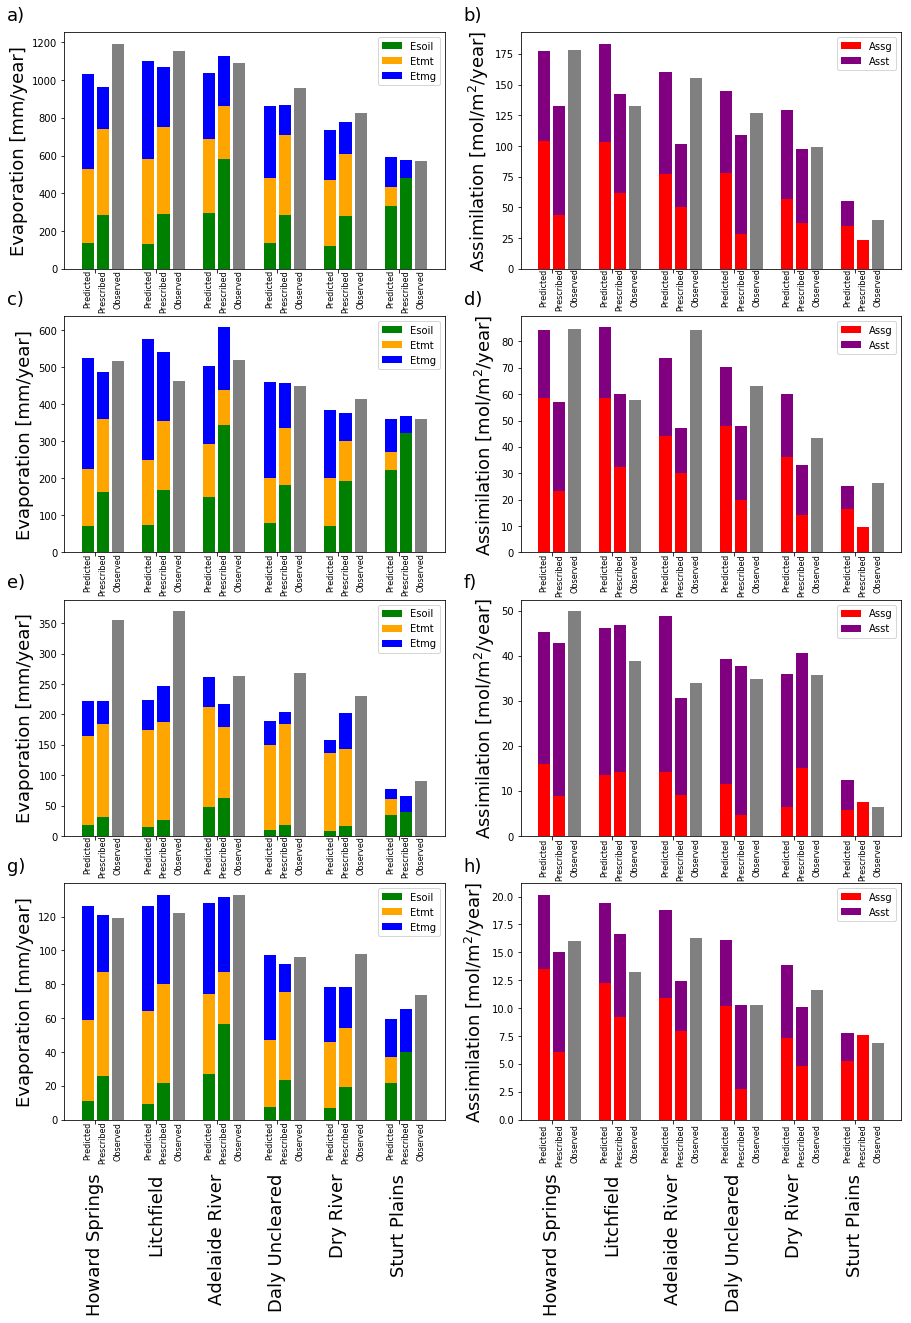

In [30]:

ind = np.arange(0,24, 4)
ind2 = ind + 1
ind3 = ind2 + 1



fig, axes   = plt.subplots(nrows=4, ncols=2, figsize=(15, 20), sharex = True )
ax = axes.flat

#################################################
p1 = ax[0].bar(ind, esoil_ma, color="green")
p2 = ax[0].bar(ind, etmt_ma, bottom=esoil_ma, color="orange")
p3 = ax[0].bar(ind, etmg_ma, bottom=np.add(etmt_ma,esoil_ma),color="blue")

p4 = ax[0].bar(ind2, esoil_ma_pc, color="green")
p5 = ax[0].bar(ind2, etmt_ma_pc, bottom=esoil_ma_pc, color="orange")
p6 = ax[0].bar(ind2, etmg_ma_pc, bottom=np.add(etmt_ma_pc,esoil_ma_pc), color="blue")

p7 = ax[0].bar(ind3, etot_dingo, color="grey")


ax[0].set_ylabel(r'Evaporation [mm/year]', fontsize=18)
ax[0].set_xticks(ind+0.5) 
ax[0].tick_params(axis="x", pad = 50)
ax[0].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18)
ax[0].legend((p1[0], p2[0], p3[0]), ('Esoil', 'Etmt', 'Etmg'))

ax[0].text(-0.15, 1.05, "a)", transform=ax[0].transAxes, 
            size=18)

for loc in ind:
    ax[0].text(loc, -40, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[0].text(loc, -40, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[0].text(loc, -40, "Observed", size=8, rotation=90, horizontalalignment='center')

    
###################################################

p1 = ax[1].bar(ind, assg_ma, color="red")
p2 = ax[1].bar(ind, asst_ma, bottom=assg_ma, color="purple")

p4 = ax[1].bar(ind2, assg_ma_pc, color="red")
p5 = ax[1].bar(ind2, asst_ma_pc, bottom=assg_ma_pc, color="purple")

p6 = ax[1].bar(ind3, gpptot_dingo, color="grey")

for loc in ind:
    ax[1].text(loc, -5, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[1].text(loc, -5, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[1].text(loc, -5, "Observed", size=8, rotation=90, horizontalalignment='center')
     
    
ax[1].set_ylabel(r'Assimilation [mol/m$^2$/year]', fontsize=18)
ax[1].set_xticks(ind+0.5) 
ax[1].tick_params(axis="x",pad = 50)
ax[1].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18 )
ax[1].legend((p1[0], p2[0]), ('Assg', 'Asst'))

ax[1].text(-0.15, 1.05, "b)", transform=ax[1].transAxes, size=18)

#########################################################
#wet season
p1 = ax[2].bar(ind, esoil_wet, color="green")
p2 = ax[2].bar(ind, etmt_wet, bottom=esoil_wet, color="orange")
p3 = ax[2].bar(ind, etmg_wet, bottom=np.add(etmt_wet,esoil_wet),color="blue")

p4 = ax[2].bar(ind2, esoil_wet_pc, color="green")
p5 = ax[2].bar(ind2, etmt_wet_pc, bottom=esoil_wet_pc, color="orange")
p6 = ax[2].bar(ind2, etmg_wet_pc, bottom=np.add(etmt_wet_pc,esoil_wet_pc), color="blue")

p7 = ax[2].bar(ind3, ewet_dingo, color="grey")


ax[2].set_ylabel(r'Evaporation [mm/year]', fontsize=18)
ax[2].set_xticks(ind+0.5) 
ax[2].tick_params(axis="x", pad = 50)
ax[2].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18)
ax[2].legend((p1[0], p2[0], p3[0]), ('Esoil', 'Etmt', 'Etmg'))

ax[2].text(-0.15, 1.05, "c)", transform=ax[2].transAxes, 
            size=18)

for loc in ind:
    ax[2].text(loc, -20, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[2].text(loc, -20, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[2].text(loc, -20, "Observed", size=8, rotation=90, horizontalalignment='center')

###################################################
#wet season assimilation
p1 = ax[3].bar(ind, assg_wet, color="red")
p2 = ax[3].bar(ind, asst_wet, bottom=assg_wet, color="purple")

p4 = ax[3].bar(ind2, assg_wet_pc, color="red")
p5 = ax[3].bar(ind2, asst_wet_pc, bottom=assg_wet_pc, color="purple")

p6 = ax[3].bar(ind3, gppwet_dingo, color="grey")

for loc in ind:
    ax[3].text(loc, -3, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[3].text(loc, -3, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[3].text(loc, -3, "Observed", size=8, rotation=90, horizontalalignment='center')
     
    
ax[3].set_ylabel(r'Assimilation [mol/m$^2$/year]', fontsize=18)
ax[3].set_xticks(ind+0.5) 
ax[3].tick_params(axis="x",pad = 50)
ax[3].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18 )
ax[3].legend((p1[0], p2[0]), ('Assg', 'Asst'))

ax[3].text(-0.15, 1.05, "d)", transform=ax[3].transAxes, size=18)


#########################################################
#dry season evaporation
p1 = ax[4].bar(ind, esoil_dry, color="green")
p2 = ax[4].bar(ind, etmt_dry, bottom=esoil_dry, color="orange")
p3 = ax[4].bar(ind, etmg_dry, bottom=np.add(etmt_dry,esoil_dry),color="blue")

p4 = ax[4].bar(ind2, esoil_dry_pc, color="green")
p5 = ax[4].bar(ind2, etmt_dry_pc, bottom=esoil_dry_pc, color="orange")
p6 = ax[4].bar(ind2, etmg_dry_pc, bottom=np.add(etmt_dry_pc,esoil_dry_pc), color="blue")

p7 = ax[4].bar(ind3, edry_dingo, color="grey")


ax[4].set_ylabel(r'Evaporation [mm/year]', fontsize=18)
ax[4].set_xticks(ind+0.5) 
ax[4].tick_params(axis="x", pad = 50)
#ax[4].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18)
ax[4].legend((p1[0], p2[0], p3[0]), ('Esoil', 'Etmt', 'Etmg'))

ax[4].text(-0.15, 1.05, "e)", transform=ax[4].transAxes, 
            size=18)

for loc in ind:
    ax[4].text(loc, -10, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[4].text(loc, -10, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[4].text(loc, -10, "Observed", size=8, rotation=90, horizontalalignment='center')


###################################################
#dry season assimilation
p1 = ax[5].bar(ind, assg_dry, color="red")
p2 = ax[5].bar(ind, asst_dry, bottom=assg_dry, color="purple")

p4 = ax[5].bar(ind2, assg_dry_pc, color="red")
p5 = ax[5].bar(ind2, asst_dry_pc, bottom=assg_dry_pc, color="purple")

p6 = ax[5].bar(ind3, gppdry_dingo, color="grey")

for loc in ind:
    ax[5].text(loc, -2, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[5].text(loc, -2, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[5].text(loc, -2, "Observed", size=8, rotation=90, horizontalalignment='center')
     
    
ax[5].set_ylabel(r'Assimilation [mol/m$^2$/year]', fontsize=18)
ax[5].set_xticks(ind+0.5) 
ax[5].tick_params(axis="x",pad = 50)
#ax[5].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18 )
ax[5].legend((p1[0], p2[0]), ('Assg', 'Asst'))

ax[5].text(-0.15, 1.05, "f)", transform=ax[5].transAxes, size=18)




#########################################################
#dry season evaporation
p1 = ax[6].bar(ind, esoil_wet2dry, color="green")
p2 = ax[6].bar(ind, etmt_wet2dry, bottom=esoil_wet2dry, color="orange")
p3 = ax[6].bar(ind, etmg_wet2dry, bottom=np.add(etmt_wet2dry,esoil_wet2dry),color="blue")

p4 = ax[6].bar(ind2, esoil_wet2dry_pc, color="green")
p5 = ax[6].bar(ind2, etmt_wet2dry_pc, bottom=esoil_wet2dry_pc, color="orange")
p6 = ax[6].bar(ind2, etmg_wet2dry_pc, bottom=np.add(etmt_wet2dry_pc,esoil_wet2dry_pc), color="blue")

p7 = ax[6].bar(ind3, ewet2dry_dingo, color="grey")


ax[6].set_ylabel(r'Evaporation [mm/year]', fontsize=18)
ax[6].set_xticks(ind+0.5) 
ax[6].tick_params(axis="x", pad = 50)
ax[6].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18)
ax[6].legend((p1[0], p2[0], p3[0]), ('Esoil', 'Etmt', 'Etmg'))

ax[6].text(-0.15, 1.05, "g)", transform=ax[6].transAxes, 
            size=18)

for loc in ind:
    ax[6].text(loc, -5, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[6].text(loc, -5, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[6].text(loc, -5, "Observed", size=8, rotation=90, horizontalalignment='center')


###################################################
#wet2dry season assimilation
p1 = ax[7].bar(ind, assg_wet2dry, color="red")
p2 = ax[7].bar(ind, asst_wet2dry, bottom=assg_wet2dry, color="purple")

p4 = ax[7].bar(ind2, assg_wet2dry_pc, color="red")
p5 = ax[7].bar(ind2, asst_wet2dry_pc, bottom=assg_wet2dry_pc, color="purple")

p6 = ax[7].bar(ind3, gppwet2dry_dingo, color="grey")

for loc in ind:
    ax[7].text(loc, -1, "Predicted", size=8, rotation=90, horizontalalignment='center')
    
for loc in ind2:
    ax[7].text(loc, -1, "Prescribed", size=8, rotation=90, horizontalalignment='center')

for loc in ind3:
    ax[7].text(loc, -1, "Observed", size=8, rotation=90, horizontalalignment='center')
     
    
ax[7].set_ylabel(r'Assimilation [mol/m$^2$/year]', fontsize=18)
ax[7].set_xticks(ind+0.5) 
ax[7].tick_params(axis="x",pad = 50)
ax[7].set_xticklabels( ('Howard Springs', 'Litchfield', 'Adelaide River', 'Daly Uncleared', 'Dry River', "Sturt Plains"),rotation=90, fontsize=18 )
ax[7].legend((p1[0], p2[0]), ('Assg', 'Asst'))

ax[7].text(-0.15, 1.05, "h)", transform=ax[7].transAxes, size=18)





plt.savefig("../data/img/10_fluxpartitioning.png", bbox_inches = "tight")
plt.show()

**Figure 10.** Partitioning of the fluxes for a) evaporation, with soil evaporation (green), tree transpiration (orange) and grass transpiration (blue) and total evaporation from the fluxtowers (grey) and b) assimilation trees (red), grasses (purple) and fluxtowers (grey). The first column represents the predicted cover, the second the prescribed cover.

## Rooting depths

### Effect of carbon costs

<Figure size 1280x1920 with 0 Axes>

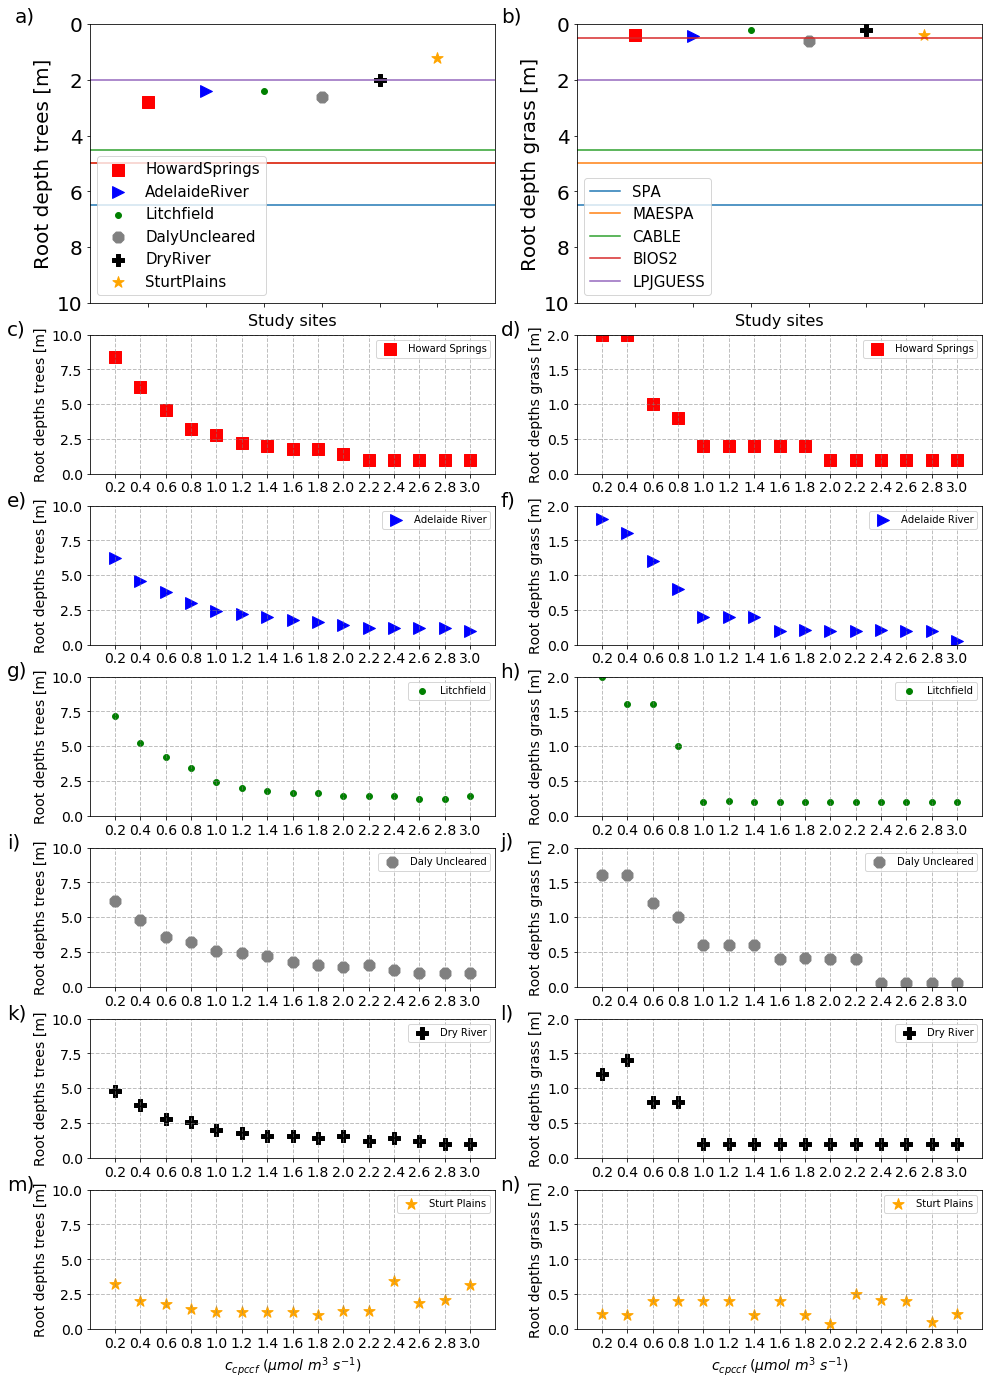

In [32]:
#plot parameters

cpcff_vals = np.arange(0.2,3.2, 0.2)
study_sites = ["HowardSprings", "AdelaideRiver", "Litchfield", "DalyUncleared", "DryRiver", "SturtPlains" ]
site_names = ["Howard Springs", "Adelaide River", "Litchfield", "Daly Uncleared", "Dry River", "Sturt Plains" ]

cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str) 

symbols = ['s', '>', '.','8', 'P','*']
colors = ['red', 'blue', 'green', 'gray', 'black', 'orange']
fig_lab = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)']



fig=plt.figure(figsize=(16, 24), dpi= 80, facecolor='w', edgecolor='k')
fig, axes  = plt.subplots(nrows=7, ncols=2, figsize=(16, 24)  , gridspec_kw={"height_ratios":[2, 1,1,1,1,1,1]}) 

ax = axes.flat

icount = 0
for isite in  range(0,6):  
    
    params_tmp = []
    #for icpcff in range(0,len(cpcff_vals)):

        #loop over files and load
    params_tmp = np.loadtxt("../work/" + 
             study_sites[isite] + "/freedrainage_cpcff1.0/best/input/pars.txt") #mm/d
        


    #for irun in range(0,4):
   
    ax[0].scatter(isite, params_tmp[5], marker=symbols[isite], color=colors[isite], s=140,label = study_sites[isite])     
    ax[1].scatter(isite, params_tmp[7], marker=symbols[isite], color=colors[isite], s=140) 
    icount = icount + 1 
    
ax[0].plot( [-1,6], [6.5,6.5])# , label='SPA'  )
ax[0].plot( [-1,6], [5, 5] )#, label='MAESPA'  )
ax[0].plot( [-1,6], [4.5,4.5])# , label='CABLE'  )
ax[0].plot( [-1,6], [5,5] )#, label='BIOS2'  )
ax[0].plot( [-1,6], [2,2] )# , label='LPJGUESS'  )   
    
ax[0].set_xlim( -1, 6  ) 
ax[0].set_ylim( 10, 0  ) 
ax[0].legend(prop={'size':15})

ax[0].set_xticks( [0,1,2,3,4,5] )  
ax[0].set_xticklabels( "", rotation=90, size=24  )  
ax[0].set_ylabel("Root depth trees [m]", size=20 )  
ax[0].set_xlabel("Study sites", size=16 )  

ax[0].text( x=-2.3, y=-0.1, s="a)", fontsize = 20)

for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

    
ax[1].plot( [-1,6], [6.5,6.5] , label='SPA'  )
ax[1].plot( [-1,6], [5, 5] , label='MAESPA'  )
ax[1].plot( [-1,6], [4.5,4.5] , label='CABLE'  )
ax[1].plot( [-1,6], [0.5,0.5] , label='BIOS2'  )
ax[1].plot( [-1,6], [2,2] , label='LPJGUESS'  )
    
#ax2.set_ylim([0,1]) 

ax[1].set_xlim( -1, 6  ) 
ax[1].set_ylim( 10, 0  ) 

ax[1].set_xticks( [0,1,2,3,4,5] )  
ax[1].set_xticklabels( "", rotation=90, size=14  )  
ax[1].set_ylabel("Root depth grass [m]", size=20 ) 
ax[1].set_xlabel("Study sites", size=16 )  

ax[1].legend(prop={'size':15})
ax[1].text( x=-2.3, y=-0.1, s="b)",  fontsize = 20)

for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(20)




ibasin = 0
iplot = 2

for site in study_sites:
    i_cpcff = 0


    for cpcff in  cpcff_str:  

        try:
            params = np.loadtxt("../work/"+  site  +"/freedrainage_cpcff" + cpcff +
                      "/best/input/pars.txt")

            rtdepth = params[5]
            rgdepth = params[7]

                
                          
            if(i_cpcff ==0):
                ax[iplot].scatter(cpcff_vals[i_cpcff], rtdepth, marker=symbols[ibasin], color=colors[ibasin] , s=140, label=site_names[ibasin])     
                ax[iplot+1].scatter(cpcff_vals[i_cpcff], rgdepth, marker=symbols[ibasin], color=colors[ibasin] , s=140, label=site_names[ibasin])     

                #ax[ibasin].plot(0.02, cai_fpar[ibasin], marker=symbols[ibasin], color=colors[ibasin] , markersize=8)     
                #ax7.text(-0.10, 1.05, fig_lab[ibasin], transform=ax[ibasin].transAxes, size=18)
            else:
                ax[iplot].scatter(cpcff_vals[i_cpcff], rtdepth, marker=symbols[ibasin], color=colors[ibasin] , s=140)     
                ax[iplot+1].scatter(cpcff_vals[i_cpcff], rgdepth, marker=symbols[ibasin], color=colors[ibasin] , s=140)     
        except OSError:
            print('file not found')       

        i_cpcff = i_cpcff + 1

                    
    ax[iplot].set_ylabel("Root depths trees [m]", size=14 )
    ax[iplot+1].set_ylabel("Root depths grass [m]", size=14 )  
    ax[iplot].set_ylim( 0, 10  ) 
    ax[iplot].set_xlim( 0, 3.2  ) 
    ax[iplot].legend(prop={'size':10})
    ax[iplot].tick_params(axis='both', which='major', labelsize=14)
    ax[iplot].set_xticks(cpcff_vals)
    ax[iplot].set_xticklabels(cpcff_str)
    ax[iplot].grid(color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax[iplot].text( x=-0.65, y=10, s=fig_lab[iplot], fontsize = 20)

    ax[iplot+1].set_ylim( 0, 2  ) 
    ax[iplot+1].set_xlim( 0, 3.2  )  
    ax[iplot+1].legend(prop={'size':10})    
    ax[iplot+1].tick_params(axis='both', which='major', labelsize=14)
    ax[iplot+1].set_xticks(cpcff_vals)
    ax[iplot+1].set_xticklabels(cpcff_str)
    ax[iplot+1].grid(color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax[iplot+1].text( x=-0.6, y=2, s=fig_lab[iplot+1], fontsize = 20)

    
    iplot = iplot + 2 
    ibasin = ibasin + 1
            
ax[iplot-1].set_xlabel(r'$c_{cpccf}$ ($\mu$$mol$ $m^3$ $s^{-1}$)', size=14 )  
ax[iplot-2].set_xlabel(r'$c_{cpccf}$ ($\mu$$mol$ $m^3$ $s^{-1}$)', size=14 ) 
 

#plt.tight_layout()
    
plt.savefig("../data/img/11_rootdepths.png", bbox_inches = "tight")

plt.show()




**Figure 11.** Modelled rooting depths for a) trees and b) grasses, with the results of the VOM shown in red. The colored lines represent the rooting depths of the other models used in Whitley et al. (2016).

### Effect on time series

<Figure size 1280x1200 with 0 Axes>

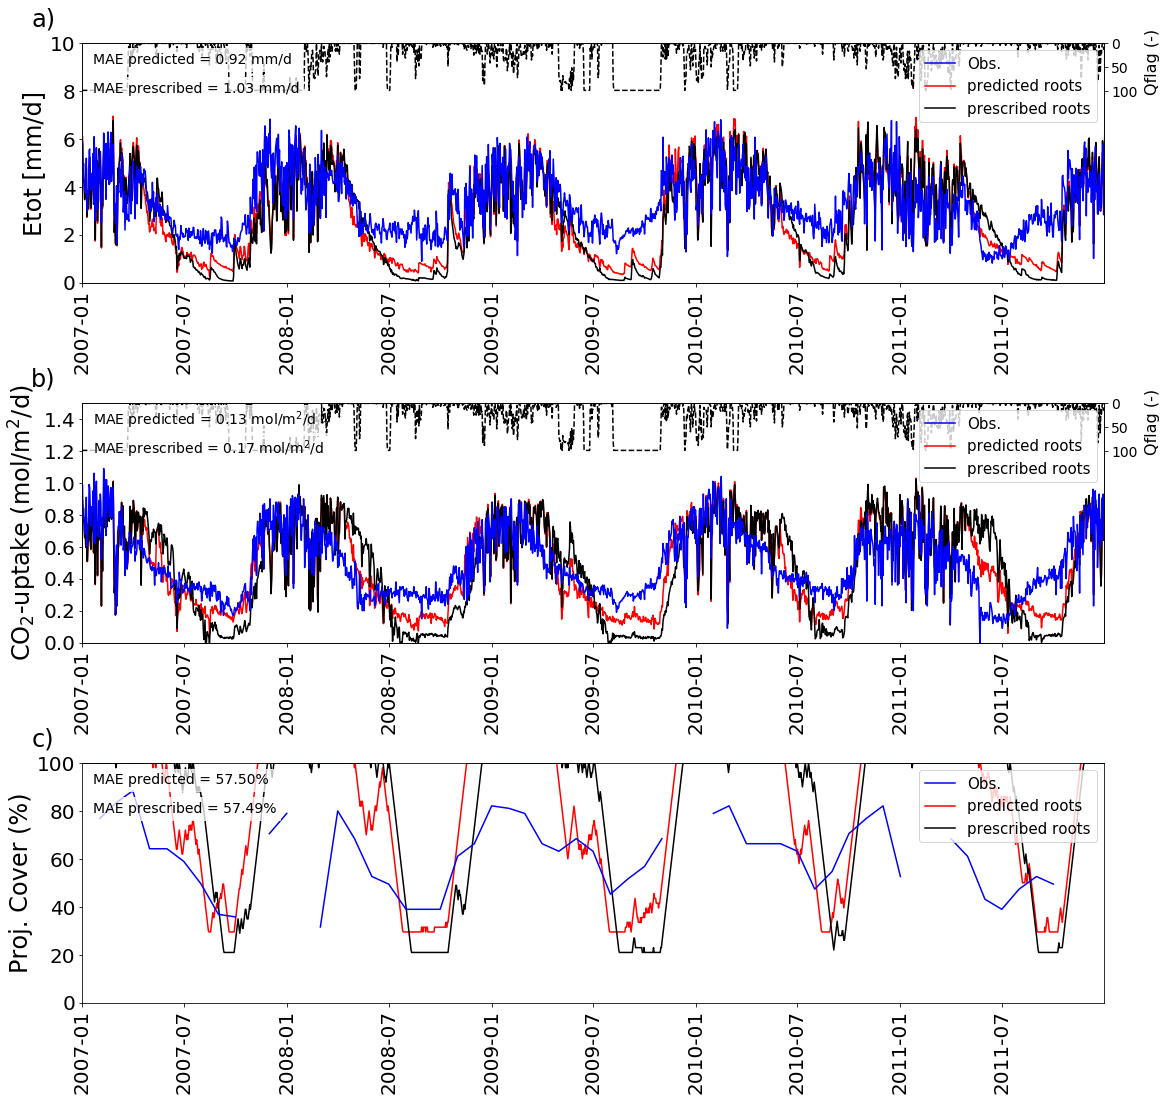

In [67]:
#HowardSprings
%run ../src_py/plot_et_ass_pc.py  \
-i ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../data/VOM_output/additional_analyses/fixed_roots/HowardSprings/sce_best/results_daily.txt \
-ys 2007 -ye 2011 -w ../data/VOM_input/HowardSprings/dailyweather.prn \
--assobs ../data/DINGO/GPPdaily_howard.txt \
--assobs_qc ../data/DINGO_QC/FcQ_howard.txt \
--eobs_qc ../data/DINGO_QC/FeQ_howard.txt \
--eobs ../data/DINGO/Ea_howard.txt \
--colors "red" "black" "green" \
--pcobs ../data/fPAR/fpar_howard_v5.txt --pcobsdates ../data/fPAR/dates_v5 \
--labels "predicted roots" "prescribed roots" --legend True  \
--stats_evap ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_stats_best/evap_beststats.txt \
../data/VOM_output/additional_analyses/fixed_roots/HowardSprings/sce_stats_best/evap_beststats.txt\
--stats_ass ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_stats_best/ass_beststats.txt \
../data/VOM_output/additional_analyses/fixed_roots/HowardSprings/sce_stats_best/ass_beststats.txt \
--stats_pc ../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_stats_best/pc_beststats.txt \
../data/VOM_output/additional_analyses/fixed_roots/HowardSprings/sce_stats_best/pc_beststats.txt \
--stats_label "MAE predicted"  "MAE prescribed" \
--xloc_title -0.05 --yloc_title 1.10  --size_title 24 

**Figure 12.** Comparison between modelled and observed fluxes for optimized rooting depths (red) and prescribed rooting depths (black) for Howard Springs of a) evaporation, b) assimilation and c) projective cover. Observations are shown in blue.